In [1]:
import os
import re
import pickle  # 保存模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.spatial import cKDTree
from sklearn.svm import SVR
from random import randint

import geopandas as gpd 
import operator 
import matplotlib.pyplot as plt
from sklearn import datasets
from ReclassifyLandUse import ReC
import NFIP_calculator
from NFIP_calculator import Insurer

import importlib
import DamageEstimation
importlib.reload( DamageEstimation )
from DamageEstimation import DepthDamage
import math
import contextily as ctx
from matplotlib.colors import rgb2hex

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
import time
from geo_northarrow import add_north_arrow
from pyogrio import read_dataframe, write_dataframe
import warnings
import seaborn as sns
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [2]:
pth11           = r"../inputs/Harzus_tool/flBldgStructDmgFn.csv"
pth22           = r"../inputs/Harzus_tool/flBldgContDmgFn.csv"
pth33           = r"../inputs/Harzus_tool/flBldgInvDmgFn.csv"

DamageFunc1     = pd.read_csv(pth11, encoding='utf-8')
DamageFunc2     = pd.read_csv(pth22, encoding='utf-8')
DamageFunc3     = pd.read_csv(pth33, encoding='utf-8')
print ("Finish read data part")


DatamagEstimator = DepthDamage( DamageFunc1, DamageFunc2, DamageFunc3)


Finish read data part
Finish read data second part


In [3]:
def floodh_adjust( probi , floodx, lgwaterdist ):
    if probi >= 0.1:
        return 0.505721 + 0.271128 * floodx - 0.07561 * lgwaterdist
    elif probi < 0.1 and probi >= 0.04:
        return 1.882091 + 0.814026 * floodx - 0.17498  * lgwaterdist
    elif probi < 0.04 and probi >= 0.02:
        return 5.392617 + 0.924160 * floodx - 0.428017 * lgwaterdist
    elif probi < 0.02 and probi >= 0.01:
        return 8.518673 + 0.883055 * floodx - 0.567981 * lgwaterdist
    else:
        return 11.73178 + 0.759123 * floodx - 0.624486 * lgwaterdist



def floodh_catediff( floodx, cate_diffs, probi ):
    if probi >= 0.1:
        return floodx + cate_diffs[0]
    elif probi < 0.1 and probi >= 0.04:
        return floodx + cate_diffs[1]
    elif probi < 0.04 and probi >= 0.02:
        return floodx + cate_diffs[2]
    elif probi < 0.02 and probi >= 0.01:
        return floodx + cate_diffs[3]
    else:
        return floodx + cate_diffs[4]

def dem_waterdist( delta_dem ):
    waterdist = 49.7718 * delta_dem
    return waterdist

print( floodh_adjust(0.9, 1.382017, 5.00987403) )

0.5016279297677


In [4]:
dictpth    = r'../inputs/saved_neighbor_dict.pkl'
with open( dictpth, 'rb' ) as f:
    GeoNeighbors = pickle.load(f)
def neghbor_prob( indx, Geodata, luc_col_name):
    #print( indx )
    nni = len( GeoNeighbors[ indx ]  )
    neighbor_probs = np.zeros( 5 ) 
    if nni > 0:
        subframei = Geodata[ Geodata['index'].isin( GeoNeighbors[indx]  ) ]
        sub_landuse_count = subframei[[luc_col_name]].value_counts()
        #print( sub_landuse_count )
        if 1 in sub_landuse_count:
            neighbor_probs[0] = sub_landuse_count[1] * 1.0 / nni
        if 2 in sub_landuse_count:
            neighbor_probs[1] = sub_landuse_count[2] * 1.0 / nni
        if 3 in sub_landuse_count:
            neighbor_probs[2] = sub_landuse_count[3] * 1.0 / nni
        if 4 in sub_landuse_count:
            neighbor_probs[3] = sub_landuse_count[4] * 1.0 / nni
        if 5 in sub_landuse_count:
            neighbor_probs[4] = sub_landuse_count[5] * 1.0 / nni
    return np.max(  neighbor_probs ), np.argmax(  neighbor_probs )



In [95]:
fp = "../inputs/gis_data/Parcel_input_sce1.shp"
#Geodata = gpd.read_file(fp)
read_start          = time.process_time()
Geodata             = read_dataframe( fp )
#Geodata['TARGET_FID']  = Geodata['index']

read_end            = time.process_time()
Geodata             = Geodata.to_crs({'init':'epsg:4326'})

In [96]:
predYrs             = 2050
deltaY              = 5
initialYrs          = 2020
#modelreplication    = 100
#Geodata['predLU']   = Geodata['LUCode20re']
#LandGrowth = 3276
ResidentialGrowth   = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                                         (Geodata["LUCode20re"] < 6), "pararea" ]) - 
                       np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                                         (Geodata["LUCode11re"] < 6), "pararea" ]) )
print(ResidentialGrowth)
#ResidentialGrowth = 39883108.19182694
predyears           = range(initialYrs, predYrs + 1, 1)
#len(predyears)

57174649.62915


In [97]:
#np.random.seed(seed=233423)

Rand_uniform = pd.read_csv( '../outputs/Rand_unifor_df.csv', encoding='utf-8')
rand_unif = np.array( Rand_uniform )
print( "rand_unif {}".format( len(rand_unif[0]) ) )
rand_heights = ( 1995.194 - 1 * np.log( -1 * np.log( rand_unif ) ) * 304.512  ) /1000/0.3048
#Rand_uniform = pd.read_csv( '../outputs/Rand_unifor_df.csv', encoding='utf-8')
#rand_unif = np.array( Rand_uniform )
#print( "Number of replication {}".format( len(rand_unif[0]) ) )


rand_unif 30


'\nplt.figure(figsize=(10, 5))\n\nplt.hist( Geodata.loc[ ( Geodata[\'DEM\'] < 50) & (Geodata[\'DEM\'] > -10) ][\'DEM\'], density=True, color="royalblue", edgecolor="blue")\nplt.hist( rand_heights[:,2] , density=True, color="lightgrey", edgecolor="darkgrey")\n\nplt.xlabel("Random storm surge heights (feet)")\nplt.ylabel("Density")\nplt.title(\'Histogram of rand_unif\')\nplt.show()\n'

In [98]:
# slrsces   =  [ 0.000003, 0.000033, 0.000103, 0.000183, 0.000183 ]
ncolumns        = len( rand_unif[0] )
nrows           = len( rand_unif )
total_parcel_N  = len(Geodata)
improvedValues  = np.zeros( total_parcel_N ) 
probLoss        = np.zeros( total_parcel_N ) 
LossPercent     = np.zeros( ( nrows, total_parcel_N ) ) 
RelocateFull    = np.zeros( ( nrows, total_parcel_N ) ) 

Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
Geodata["LUC"]      = Geodata['LUCode20re']
Geodata['LANDUSE']  = Geodata['LANDUSE'].fillna('')
Geodata["Year"]   = Geodata.apply(lambda x: x['YEARBUILT'] if x['VAL19IMP'] > 0 else 0 , axis=1) ############
Geodata["Year"]   = Geodata.apply(lambda x: randint(1980, 2020) if x['VAL19IMP'] > 0 and x['Year'] == 0 else 0 , axis=1) ############

print(Geodata.Year.value_counts())
damage_count_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
ploss_count_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
damage_perct_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)

impvi_b0 = np.random.normal(159961.40, 2543.65, size = total_parcel_N)
impvi_b1 = np.random.normal(158.84, 55.61, size = total_parcel_N)
growth_agg      = 5
LandGrowth      = np.round( ResidentialGrowth * growth_agg / 10)
year0           = predyears[ 0 ] ############
year1           = predyears[ 0 ] + growth_agg ############

for i in range( nrows-1, nrows  ):
    slrH   = 0
    para_b = 0.000003
    if i % 5 == 0:
        print( "Iteration {}".format( i ) )
    for yith in range( ncolumns ):
        #heighti  = rand_heights[i, yith] #feet
        probi    = rand_unif[i, yith]
        yeark    = predyears[ yith ]
        #print("Simulation year ", yeark, " ", growth_agg)
        if yith >= 1 and para_b > 0:
            rate = ( 0.0017*( yeark ) + para_b*( ( yeark )** 2) ) - ( 0.0017*( yeark -1) + para_b*( (yeark -1) ** 2) )
        else:
            rate = 0 
        slrH    = (slrH + rate ) * 1000;
        sigmai  = 304.512
        mui     = 1995.194 + slrH
        heighti = ( mui - 1 * np.log( -1 * np.log( probi ) ) * sigmai ) /304.8
        distchange = dem_waterdist( (slrH )/304.8 ) 
        totalDamage_i = 0
        if ( (yith + 1) % growth_agg == 0) and i == nrows - 1:
            #Geodata_dict  = Geodata.to_dict('records')
            LandGrowth_agg    = np.round( LandGrowth )
            print( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  )
            print( Geodata.loc[( Geodata["LUC"] > 0 ) & (Geodata["LUC"] < 6)].pararea.sum(), " ", LandGrowth  )
            landuseProb       = np.zeros( total_parcel_N ) 
            landuselist       = np.zeros( total_parcel_N ) 
            NeighbiorLU       = np.zeros( total_parcel_N ) 
            landuseType       = np.zeros( total_parcel_N ) 
            idx_parcel =  0
            Geodata_dict        = Geodata.to_dict('records')
            for rowi in Geodata_dict:
                if yith + 1 == growth_agg  :
                    if rowi['LUC']  <= 0 :
                        improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                        landuseType[ idx_parcel]       = 0
                        landuseProb[ idx_parcel]       = 0.0
                        #CoastDist
                    elif ( rowi['floodzones'] in [3, 10] and rowi['WaterCoast'] < 2000  ) :
                        if ( rowi['Risk'] > 1  and rowi['LUC'] > 0 and rowi['LUC'] <= 5 ):
                            landuseProb[ idx_parcel]       = 0.0
                            improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                            landuseType[ idx_parcel]       = 0
                            LandGrowth_agg = LandGrowth_agg + rowi['pararea']
                            Geodata.at[ rowi['TARGET_FID'], 'LUC' ]   = 0  
                            Geodata.at[ rowi['TARGET_FID'], 'Year' ] = randint(year0, year1)

                if rowi['floodzones'] in [3, 10]:
                    landuseProb[ idx_parcel]      +=  -1.0
                    landuseType[ idx_parcel]       =  rowi['LUC'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                elif rowi['LUC']   <= 5 and rowi['LUC'] >= 0 and rowi['VAL19IMP'] > 0:
                    landuseProb[ idx_parcel]      +=  -1.0
                    landuseType[ idx_parcel]       =  rowi['LUC'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                elif "UW" in rowi['LANDUSE'] or rowi['LANDUSE'] == 0 :
                    landuseProb[ idx_parcel]      += -1.0 
                    improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                    landuseType[ idx_parcel]       = rowi['LUC'] 
                    rowi['LUC']                    = rowi['LUC'] 
                elif rowi['LUC']   != rowi['LUCode20re'] :
                    landuseProb[ idx_parcel]       =  0.0 
                    landuseType[ idx_parcel]       =  rowi['LUC'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']  
                elif (rowi['poicode'] == 2204 or rowi['poicode'] == 2082 or 
                        rowi['poicode'] == 2081) :
                    landuseProb[ idx_parcel]       =  0.0
                    landuseType[ idx_parcel]       =  rowi['LUC']  
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP'] 
                elif rowi['parkigcode'] > 0 :
                    landuseProb[ idx_parcel]       =  0.0 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                    landuseType[ idx_parcel]       =  rowi['LUC'] 
                elif rowi['watercode'] > 0 :
                    landuseProb[ idx_parcel]       =  0.0 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                    landuseType[ idx_parcel]       =  rowi['LUC']  
                    #landuseProb[idx_parcel]       =  -1.0 
                    #landuseType[ idx_parcel]       =  0
                    #improvedValues[ idx_parcel]    =  0.0
                    #LandGrowth = LandGrowth + rowi['pararea']
                    #print("Loss")
                else:
                    #if rowi['LUC'] > 0 and rowi['LUC'] < 5 and rowi['VAL19IMP'] <= 0:
                    #    print("Error LU developed ", rowi['LUC'], rowi['VAL19IMP'], rowi['LUCtype'])
                    #if rowi['LUC']   != rowi['LUCode20re'] :
                    urban_neighbor_probs = neghbor_prob( rowi['TARGET_FID'], Geodata, 'LUC')
                    #else:
                    #neigbors_p = rowi[ ['NN1', 'NN2', 'NN3', 'NN4', 'NN5'] ] 
                    #urban_neighbor_probs = np.max( neigbors_p ), np.argmax( neigbors_p )
                    maxlu         = rowi['predLU']
                    if maxlu == urban_neighbor_probs[1]+ 1 and maxlu == rowi['LUCode'] :
                        landuseType[ idx_parcel]       =  maxlu
                        landuseProb[ idx_parcel]  = rowi['predprobs']
                    elif urban_neighbor_probs[1] + 1 ==  rowi['LUCode']:
                        landuseType[ idx_parcel]  =  urban_neighbor_probs[1] + 1
                        landuseProb[ idx_parcel]  = urban_neighbor_probs[0]
                    else:
                        landuseType[ idx_parcel]  = maxlu
                        landuseProb[ idx_parcel]  = rowi['predprobs']
                    #impvi = impvi_b0[ idx_parcel ] +\
                    #        impvi_b1[ idx_parcel ] * rowi["pararea"]                 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP'] 
                idx_parcel = idx_parcel + 1
            Geodata["LUCprob"]  = landuseProb
            Geodata["LUCtype"]  = landuseType
            Geodata["ImproVal"] = improvedValues    
            print( "Year ", yeark," LUCtype ", Geodata["LUCtype"].unique() )
            #Geodata["LUC"]     = landuse
            Geodata.sort_values("LUCprob", ascending = False, inplace = True)
            Geodata["rank"]     = Geodata.reset_index().index +1
            Geodata["PAreaCum"] = Geodata["pararea"].cumsum()
            lengthi             = Geodata["PAreaCum"].searchsorted(LandGrowth_agg, side='right') + 1
            print( "length of pararea", lengthi )
            temnlu              = len( Geodata.loc[( Geodata["LUC"] > 0 ) & (Geodata["LUC"] < 6)] )
            #results1 = []
            #results2 = []
            Geodata_dict2  = Geodata.to_dict('records')
            count_rank = 0
            for rowi2 in Geodata_dict2:
                if rowi2["rank"] < lengthi:
                    Geodata.at[ rowi2['index'], 'LUC' ] = rowi2['LUCtype']
                    Geodata.at[ rowi2['index'], 'Year' ] = randint(year0, year1)
                    if rowi2['LUC']  <= 5 and rowi2['LUC'] >= 1 and rowi2['ImproVal'] == 0:
                        impvi = impvi_b0[ count_rank ] +\
                                impvi_b1[ count_rank ] * rowi2["pararea"]    
                        if impvi == 0:
                            print( "Improvement value error1 ", rowi2['VAL19IMP'] )
                        Geodata.at[ rowi2['index'], 'VAL19IMP' ] = impvi 
                    else:
                        Geodata.at[ rowi2['index'], 'VAL19IMP' ] = rowi2['ImproVal']
                else:
                    if rowi2['LUCtype'] == 0:
                        Geodata.at[ rowi2['index'], 'LUC' ] =  rowi2['LUCtype']
                count_rank = count_rank + 1 
            #   Geodata.loc[ Geodata["rank"] < lengthi, "LUC"]      = Geodata.loc[ Geodata["rank"] < lengthi, "LUCtype"]
            #   Geodata.loc[ Geodata["rank"] < lengthi, "VAL19IMP"] = Geodata.loc[ Geodata["rank"] < lengthi, "ImproVal"]
            #Geodata['LUC']      = results1
            #Geodata['VAL19IMP'] = results2
            year0 = yeark
            year1 = yeark + growth_agg
            #print( "Updated ",Geodata.LUC.unique() )
            change_yeari = len( Geodata.loc[( Geodata["LUC"] > 0 ) & (Geodata["LUC"] < 6)] ) - temnlu
            print( "# parcels diff ", change_yeari )
print( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  )
print( Geodata.loc[( Geodata["LUC"] > 0 ) & (Geodata["LUC"] < 6)].pararea.sum(), " ", LandGrowth  )


Year
0       66758
1980     2624
1991     2617
2005     2604
2014     2585
2020     2578
2019     2569
2008     2568
2006     2566
2011     2563
1981     2548
1993     2548
1985     2545
1996     2543
1984     2540
2007     2538
2017     2537
1994     2534
1983     2532
1998     2528
1992     2526
1982     2524
2018     2521
2003     2516
2016     2514
2009     2510
2012     2505
1990     2503
1989     2501
1995     2500
2001     2497
2002     2484
1986     2484
2004     2484
2010     2477
2015     2475
1988     2472
2000     2469
1987     2469
1999     2460
2013     2452
1997     2426
Name: count, dtype: int64
257568690.85302788
257568690.85302788   28587325.0
Year  2024  LUCtype  [6. 2. 1. 5. 7. 4. 3.]
length of pararea 8488
# parcels diff  2261
257568690.8530279
269055433.6247179   28587325.0
Year  2029  LUCtype  [2. 1. 3. 4. 5. 7. 6. 0.]
length of pararea 5700
# parcels diff  3042
257568690.8530279
291203742.9391579   28587325.0
Year  2034  LUCtype  [3. 2. 4. 1. 5. 6. 7. 0.]
length

In [9]:

color_mapping = { 0: "aqua", 1: "gold", 2: "firebrick",
                  3: "pink", 4: "mediumorchid", 5: "orange", 
                  6: "darkgreen", 7 : "limegreen"}


label_mapping = { 0: "Retired residential land", 1: "residential land",
                  2: "commercial land", 3: "industrial land", 
                  4: "infrastructural land", 5: "public land",
                  6: "green land", 7 : "open space"}

#Geodata["Colors"] = Geodata["LUC"].map(color_mapping)
#Geodata["LUName"] = Geodata["LUC"].map(label_mapping)



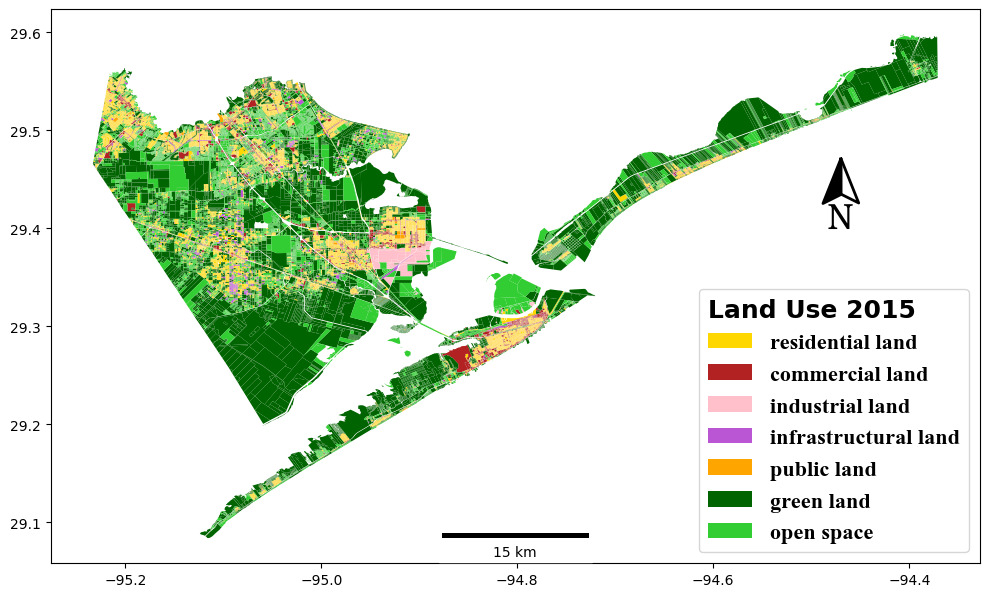

In [33]:
'''
fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUCode15re'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop = {'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles = [ *handles,*pmarks ],
            title = "Land Use 2015",
            title_fontsize = 'xx-large', 
            loc = 'lower right',
            fontsize = 14,
            frameon  = True )
leg._legend_box.align = "left"
legend = ax.get_legend()
legend.set_title( "Land Use 2015" , prop={'size' : 18, 'weight':'bold'})

x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)
plt.tight_layout()

plt.savefig('../output_images/LandUse_test2015.png',dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
'''


In [181]:
Geodata.LUC.value_counts()

LUC
1    132424
6     21171
2      6479
7      5119
4      3810
5      1004
3       174
0        13
Name: count, dtype: int64

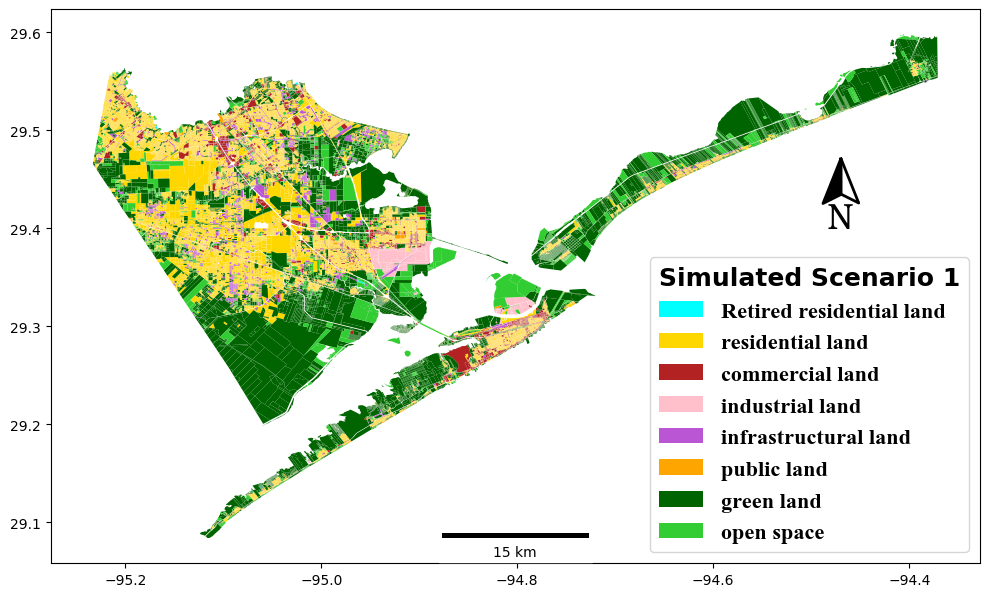

In [101]:
#fp = "../inputs/gis_data/Parcel_output_sce1.shp"
##Geodata = gpd.read_file(fp)
#read_start          = time.process_time()
#Geodata             = read_dataframe( fp )
#read_end            = time.process_time()
#Geodata      = Geodata.to_crs({'init':'epsg:4326'})

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUC'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color = color, label = labeli ,
              ax = ax, linewidth=.01, 
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'}, #, 'weight': 'bold'
            handles=[ *handles,*pmarks ],
            title= r"Simulated Scenario 1",
            title_fontsize='xx-large', 
            loc = 'lower right',
            fontsize= 14,
            frameon= True )
leg._legend_box.align = "left"
legend = ax.get_legend()
legend.set_title( "Simulated Scenario 1" , prop={'size' : 18, 'weight':'bold'})
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()

#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)
plt.tight_layout()

#plt.savefig('../output_images/LandUse_test1_2.png',dpi=600, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/LandUse_test1_2.pdf', bbox_inches='tight', pad_inches=0)

plt.show()



In [102]:

Geodata_select = gpd.GeoDataFrame( Geodata , geometry = 'geometry', crs="EPSG:4326")
write_dataframe(Geodata_select, path= r'../inputs/gis_data/Parcel_output_sce1.shp',
                        driver='ESRI Shapefile')


In [104]:
Geodata.Year.value_counts()

Year
0       50554
2020     3930
1991     2533
1980     2532
2014     2503
        ...  
2043      219
2049      217
2040      207
2045      205
2047      181
Name: count, Length: 71, dtype: int64

# Simulation Scenario 2

In [5]:

fp = "../inputs/gis_data/Parcel_input_sce2.shp"
#Geodata = gpd.read_file(fp)
read_start          = time.process_time()
Geodata             = read_dataframe( fp )
read_end            = time.process_time()
Geodata      = Geodata.to_crs({'init':'epsg:4326'})

In [6]:
# slrsces   =  [ 0.000003, 0.000033, 0.000103, 0.000183, 0.000183 ]
predYrs             = 2050
deltaY              = 5
initialYrs          = 2020
Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
Geodata["LUC2"]      = Geodata['LUCode20re']
Geodata_dict = Geodata.to_dict('records')
def_value = 0
damage_count_dict2 = dict.fromkeys( Geodata.TARGET_FID.to_list() ,def_value)
damage_perct_dict2 = dict.fromkeys( Geodata.TARGET_FID.to_list() ,def_value)

ResidentialGrowth = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                                         (Geodata["LUCode20re"] < 6), "pararea" ]) - 
                     np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                                         (Geodata["LUCode11re"] < 6), "pararea" ]) )

print(ResidentialGrowth)
#ResidentialGrowth = 39883108.19182694
predyears = range(initialYrs, predYrs + 1, 1)
print( len(predyears) )
LandGrowth        = np.round( ResidentialGrowth ) * deltaY / 10.0
print(LandGrowth)
Geodata['LANDUSE'] = Geodata['LANDUSE'].fillna('')
Geodata["Year2"]   = Geodata.apply(lambda x: x['YEARBUILT'] if x['VAL19IMP'] > 0 else 0 , axis=1) ############
Geodata["Year2"]   = Geodata.apply(lambda x: randint(1980, 2020) if x['VAL19IMP'] > 0 and x['Year2'] == 0 else 0 , axis=1) ############


growth_agg          = deltaY
rand_unif = stats.uniform.rvs(loc= 0, scale= 1, 
                              size= ( 1, predYrs - initialYrs ) )

Aggregate_Year                  = pd.DataFrame()
Aggregate_Year["Year"]          = predyears
aggregate_damage_dict2 = dict.fromkeys( Aggregate_Year.Year.to_list() ,def_value)


57174649.62915
31
28587325.0


In [186]:
print( Geodata.shape, " ", Geodata.loc[ Geodata['floodzones'].isin( [3, 10] ) ].shape )
print( Geodata.loc[ (Geodata['floodzones'].isin( [3, 10] )) | ( (Geodata['LUC2']<= 5)&(Geodata['LUC2']>0)&(Geodata['VAL19IMP'] > 0) ) ].shape )

predyears
rand_unif[0]

(170194, 85)   (70992, 85)
(144642, 85)


array([0.51018582, 0.60665939, 0.62868697, 0.85436841, 0.92859216,
       0.47947298, 0.77608111, 0.0424799 , 0.87240436, 0.20151095,
       0.07268167, 0.61883292, 0.52371566, 0.57454689, 0.8876877 ,
       0.75607519, 0.94029533, 0.54165134, 0.76541235, 0.96920477,
       0.0130752 , 0.08680601, 0.09820307, 0.70515549, 0.34155376,
       0.40715138, 0.83869781, 0.54736449, 0.79651643, 0.10549435])

In [7]:
ncolumns        = len( rand_unif[0] )
nrows           = len( rand_unif )
total_parcel_N  = len( Geodata )
improvedValues  = np.zeros( total_parcel_N ) 
changes         = np.zeros( total_parcel_N ) 
impvi_b0        = np.random.normal(159961.40, 2543.65, size = total_parcel_N)
impvi_b1        = np.random.normal(158.84, 55.61, size = total_parcel_N)
year0           = predyears[ 0 ] ############
year1           = predyears[ 0 ] + deltaY ############
for i in range( nrows  ):
    slrH   = 0
    para_b = 0.000003
    if i % 5 == 0:
        print( "Iteration {}".format( i ) )
    for yith in range( ncolumns ):
        #heighti  = rand_heights[i, yith] #feet
        probi    = rand_unif[i, yith]
        yeark    = predyears[ yith ]
        if yith >= 1 and para_b > 0:
            rate = ( 0.0017*( yeark ) + para_b*( ( yeark )** 2) ) - ( 0.0017*( yeark -1) + para_b*( (yeark -1) ** 2) )
        else:
            rate = 0 
        slrH    = (slrH + rate ) * 1000;
        sigmai  = 304.512
        mui     = 1995.194 + slrH
        heighti = ( mui - 1 * np.log( -1 * np.log( probi ) ) * sigmai ) /304.8
        distchange = dem_waterdist( (slrH )/304.8 ) 
        """" update probs from gbdt"""
        totalDamage_i     = 0
        if ( (yith + 1) % growth_agg == 0) and i == nrows - 1:
            #if yith > growth_agg - 1:
            #    Geodata_dict = Geodata.to_dict('records')
            LandGrowth_agg        = np.round( LandGrowth ) 
            print( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  )
            print( Geodata.loc[( Geodata["LUC2"] > 0 ) & (Geodata["LUC2"] < 6)].pararea.sum(), " ", LandGrowth_agg  )
            landuseProb       = np.zeros( total_parcel_N ) 
            landuselist       = np.zeros( total_parcel_N ) 
            NeighbiorLU       = np.zeros( total_parcel_N ) 
            landuseType       = np.zeros( total_parcel_N ) 
            idx_parcel        =  0
            Geodata_dict  = Geodata.to_dict('records')
            for rowi in Geodata_dict:
                if rowi['DEM'] < heighti and rowi['DEM'] > 0:
                    floodhi  = heighti - rowi['DEM']  
                elif rowi['DEM'] < 0 :
                    floodhi  = heighti
                else:
                    floodhi  = 0
                #logdisti = np.log( rowi['WaterCoast'] )
                #print( "Year ",yith  )
                if yith + 1 == growth_agg  :
                    if rowi['LUC2']  <= 0 :
                        improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                        landuseType[ idx_parcel]       = 0
                        landuseProb[ idx_parcel]       = 0.0
                        #CoastDist
                    elif ( rowi['floodzones'] in [3, 10] and rowi['WaterCoast'] < 2000  ) :
                        if ( ( rowi['Risk']*rowi['VAL19TOT'] + rowi["Insurance"] * 22.8 )  > rowi['VAL19TOT'] and
                            rowi['LUC2'] > 0 and rowi['LUC2'] <= 5 ):
                            landuseProb[ idx_parcel]       = 0.0
                            improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                            landuseType[ idx_parcel]       = 0
                            LandGrowth_agg = LandGrowth_agg + rowi['pararea']
                            Geodata.at[ rowi['TARGET_FID'], 'LUC2' ]   = 0  
                            Geodata.at[ rowi['TARGET_FID'], 'Year2' ] = randint(year0, year1)
                if rowi['floodzones'] in [3, 10]:
                    landuseProb[ idx_parcel]      +=  -1.0
                    landuseType[ idx_parcel]       =  rowi['LUC2'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                elif rowi['LUC2']   <= 5 and rowi['LUC2'] >= 0 and rowi['VAL19IMP'] > 0:
                    landuseProb[ idx_parcel]      +=  -1.0
                    landuseType[ idx_parcel]       =  rowi['LUC2'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                    #if rowi['LUC2'] > 0 and rowi['LUC2'] < 5:
                    #    print("??? LU developed ", rowi['LUC2'], row['VAL19IMP'], row['LANDUSE'])
                elif "UW" in rowi['LANDUSE'] or rowi['LANDUSE'] == 0 :
                    landuseProb[ idx_parcel]       += 0.0 
                    improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                    landuseType[ idx_parcel]       = rowi['LUC2']
                    #Geodata.at[ rowi['TARGET_FID'], 'LUC2' ]   = rowi['LUC2']
                elif (rowi['poicode'] == 2204 or rowi['poicode'] == 2082 or 
                        rowi['poicode'] == 2081) :
                    landuseProb[ idx_parcel]       = 0.0
                    landuseType[ idx_parcel]       = rowi['LUCode11re']  
                    improvedValues[ idx_parcel]    = rowi['VAL19IMP'] 
                elif rowi['parkigcode'] > 0 or rowi['watercode'] > 0 :
                    landuseProb[ idx_parcel]       = 0.0 
                    improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                    landuseType[ idx_parcel]       =  rowi['LUC2'] 
                elif rowi['LUC2']   != rowi['LUCode20re'] :
                    landuseProb[idx_parcel]       +=  -1.0 
                    landuseType[ idx_parcel]       =  rowi['LUC2'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']  
                # elif damage_perct_dict[ rowi['TARGET_FID'] ] > rowi['VAL19TOT'] * 2 * nrows and rowi['VAL19IMP'] > 10000:
                #     landuseProb[idx_parcel]       +=  -1.0 
                #     landuseType[ idx_parcel]       =  0
                #     improvedValues[ idx_parcel]    =  rowi['VAL19IMP']     
                else:
                    urban_neighbor_probs = neghbor_prob( rowi['TARGET_FID'], Geodata, 'LUC2')
                    maxlu         = rowi['predLU']
                    if maxlu == urban_neighbor_probs[1]+ 1 and maxlu == rowi['LUCode'] :
                        landuseType[ idx_parcel]  =  maxlu
                        landuseProb[ idx_parcel]  = rowi['predprobs']
                    elif urban_neighbor_probs[1] + 1 ==  rowi['LUCode']:
                        landuseType[ idx_parcel]  =  urban_neighbor_probs[1] + 1
                        landuseProb[ idx_parcel]  = urban_neighbor_probs[0]
                    else:
                        landuseType[ idx_parcel]  = maxlu
                        landuseProb[ idx_parcel]  = rowi['predprobs']              
                    improvedValues[ idx_parcel]   =  rowi['VAL19IMP']  
                #landuselist[ idx_parcel ] = rowi['LUC2']  
                idx_parcel = idx_parcel + 1

            Geodata["LUCprob"]  = landuseProb
            Geodata["LUCtype"]  = landuseType
            Geodata["ImproVal"] = improvedValues    
            #Geodata["LUC2"]     = landuselist
            Geodata.sort_values("LUCprob", ascending = False, inplace = True)
            Geodata["rank"]     = Geodata.reset_index().index + 1
            Geodata["PAreaCum"] = Geodata["pararea"].cumsum()
            lengthi             = Geodata["PAreaCum"].searchsorted( LandGrowth_agg, side='right') + 1
            print( "length of pararea", lengthi )
            temnlu              = len( Geodata.loc[( Geodata["LUC2"] > 0 ) & (Geodata["LUC2"] < 6)] )
            results1 = []
            results2 = []
            Geodata_dict2  = Geodata.to_dict('records')
            count_rank = 0
            #for idx2 , rowi2 in Geodata.iterrows():
            for rowi2 in Geodata_dict2:
                if rowi2["rank"] < lengthi:
                    #print( rowi2.predprobs, " ", rowi2.LUC2 )
                    Geodata.at[ rowi2['index'], 'LUC2' ] = rowi2['LUCtype']
                    Geodata.at[ rowi2['index'], 'Year2' ] = randint(year0, year1) 
                    if rowi2['LUC2'] <= 5 and rowi2['LUC2'] >= 1 and rowi2['ImproVal'] == 0:
                        impvi = impvi_b0[ count_rank ]  + impvi_b1[ count_rank ]  * rowi2['pararea']  
                        #print("urban land use value 0 ", rowi2['LUC2'])   
                        Geodata.at[ rowi2['index'], 'VAL19IMP' ] = impvi
                    else:
                        Geodata.at[ rowi2['index'], 'VAL19IMP' ] = rowi2['ImproVal']
                else:
                    if rowi2['LUCtype'] == 0:
                        Geodata.at[ rowi2['index'], 'LUC2' ] =  0 #Geodata.at[ rowi2.Index, 'LUC2' ] = rowi2.LUC2
                count_rank = count_rank + 1 
            year0 = yeark
            year1 = yeark + deltaY
            change_yeari = len( Geodata.loc[( Geodata["LUC2"] > 0 ) & (Geodata["LUC2"] < 6)] ) - temnlu
            print( "# parcels diff ", change_yeari )
            Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
        #aggregate_damage_dict2[ yeark ] = aggregate_damage_dict[ yeark ] + totalDamage_i
print( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  )
print( Geodata.loc[( Geodata["LUC2"] > 0 ) & (Geodata["LUC2"] < 6)].pararea.sum(), " ", LandGrowth_agg  )


Iteration 0
257568690.85302788
257568690.85302788   28587325.0
length of pararea 14896
# parcels diff  5611
257568690.85302788
262108245.98665792   28587325.0
length of pararea 1507
# parcels diff  892
257568690.85302788
288157978.0666579   28587325.0
length of pararea 1372
# parcels diff  962
257568690.85302788
314587546.7679579   28587325.0
length of pararea 1481
# parcels diff  918
257568690.85302788
340750041.2937689   28587325.0
length of pararea 1544
# parcels diff  827
257568690.85302788
367065577.73326886   28587325.0
length of pararea 1919
# parcels diff  1084
257568690.85302788
391715534.15276885   28587325.0


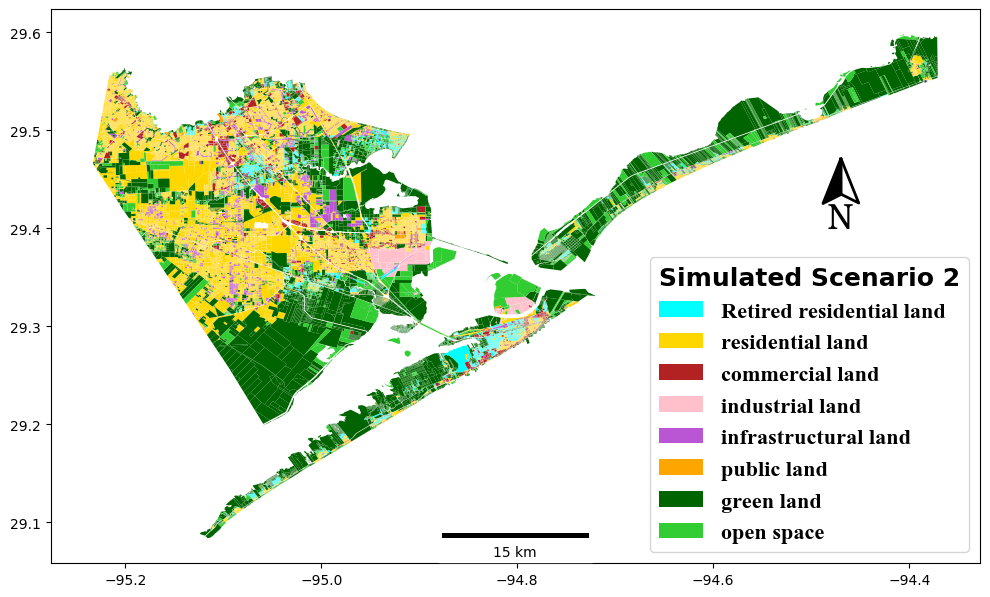

In [11]:
#fp = "../inputs/gis_data/Parcel_output_sce2.shp"
##Geodata = gpd.read_file(fp)
#read_start          = time.process_time()
#Geodata             = read_dataframe( fp )
#read_end            = time.process_time()
#Geodata      = Geodata.to_crs({'init':'epsg:4326'})

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUC2'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="Simulated Scenario 2",
            title_fontsize='xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon=True )
leg._legend_box.align = "left"

legend = ax.get_legend()
legend.set_title( "Simulated Scenario 2" , prop={'size' : 18, 'weight':'bold'})
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)

plt.tight_layout()
#plt.savefig('../output_images/LandUse_test2_2.png',dpi= 900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/LandUse_test2_3.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [87]:
Geodata_select = gpd.GeoDataFrame( Geodata , geometry = 'geometry', crs="EPSG:4326")
write_dataframe(Geodata_select, 
                path= r'../inputs/gis_data/Parcel_output_sce2.shp',
                driver='ESRI Shapefile')


In [88]:
Geodata.Year2.value_counts()

Year2
0       39583
2020     8272
2024     6554
2025     6457
2022     6357
        ...  
2041      245
2040      243
2036      243
2043      216
2042      207
Name: count, Length: 71, dtype: int64

# Scenario 3 simulation

In [105]:
fp = "../inputs/gis_data/Parcel_input_sce3.shp"
#Geodata = gpd.read_file(fp)
read_start   = time.process_time()
Geodata      = read_dataframe( fp )
read_end     = time.process_time()
Geodata      = Geodata.to_crs({'init':'epsg:4326'})
# 0.0201 property tax


In [234]:
Geodata.columns

Index(['index', 'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE',
       'landCode', 'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode',
       'waterclass', 'watername', 'parkigcode', 'parkigclas', 'LUCode01re',
       'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode',
       'policyCost', 'policyCoun', 'elevationN', 'Content_Bu', 'ACRES',
       'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'NumStories', 'Foundation',
       'FirstFloor', 'ContentCos', 'BldgDamage', 'CDDF_ID', 'YEARBUILT',
       'Tract', 'Insurance', 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
       'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority',
       'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist',
       'CoastDist', 'WetlatDist', 'floodzones', 'buildDEM', 'PArea',
       'slope_mhw', 'logAccess', 'area_2', 'pararea', 'Risk', 'NN1', 'NN2',
       'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2', 'WaterCoast',
       'predprobs', 'predLU', 'cate1d

In [106]:
predYrs             = 2050
deltaY              = 5
initialYrs          = 2020
Geodata["LUC3"]      = Geodata['LUCode20re']

ResidentialGrowth = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                                         (Geodata["LUCode20re"] < 6), "pararea" ]) - 
                     np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                                         (Geodata["LUCode11re"] < 6), "pararea" ]) )

print(ResidentialGrowth)
#ResidentialGrowth = 39883108.19182694
growth_agg          = deltaY
predyears = range(initialYrs, predYrs+1, 1)
LandGrowth        = np.round( ResidentialGrowth * growth_agg / 10.0)
print( "Number of steps {}".format( len(predyears) ) )
Geodata['LANDUSE'] = Geodata['LANDUSE'].fillna('')
print("LandGrowth ", LandGrowth)
Geodata_dict = Geodata.to_dict('records')

Aggregate_Year                  = pd.DataFrame()
Aggregate_Year["Year"]          = predyears
aggregate_damage_dict = dict.fromkeys( Aggregate_Year.Year.to_list() , 0)
modelreplication      = 5
#rand_unif = stats.uniform.rvs(loc= 0, scale= 1, 
#                              size= ( modelreplication, predYrs - initialYrs ) )

Rand_uniform = pd.read_csv( '../outputs/Rand_unifor_df.csv', encoding='utf-8')
rand_unif = np.array( Rand_uniform )
print( len(rand_unif[0]) )

rand_heights = ( 1995.194 - 1 * np.log( -1 * np.log( rand_unif ) ) * 304.512  ) /1000/0.3048
ncolumns    = len( rand_unif[0] )
nrows       = len( rand_unif )
DatamagEstimator       = DepthDamage( DamageFunc1, DamageFunc2, DamageFunc3)
print( "nrows is {}, and ncolumns is {}".format(nrows, ncolumns) )


57174649.62915
Number of steps 31
LandGrowth  28587325.0
30
Finish read data second part
nrows is 100, and ncolumns is 30


In [231]:
#( 1995.194 - 1 * np.log( -1 * np.log( 0.1 ) ) * 304.512  ) /1000/0.3048
Geodata.TARGET_FID.min(), Geodata.TARGET_FID.max(), len(Geodata.TARGET_FID.unique()), Geodata.shape, nrows

(0, 170193, 170194, (170194, 85), 100)

In [107]:
ncolumns        = len( rand_unif[0] )
nrows           = len( rand_unif )
total_parcel_N  = len( Geodata )
improvedValues  = np.zeros( total_parcel_N ) 
probLoss        = np.zeros( total_parcel_N ) 
LossPercent     = np.zeros( ( nrows, total_parcel_N ) ) 
RelocateFull    = np.zeros( ( nrows, total_parcel_N ) ) 
damage_perct_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
impvi_b0        = np.random.normal(159961.40, 2543.65, size = total_parcel_N)
impvi_b1        = np.random.normal(158.84, 55.61, size = total_parcel_N)
slrH            = 0
para_b          = 0.000003
for i in range( nrows  ): #
    slrH = 0
    damage_count_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
    ploss_count_dict  = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)

    if i % 5 == 0:
        print( "Replication {}".format( i ) )
    Geodata["LUC3"]      = Geodata['LUCode20re']
    Geodata["VALIMP"]    = Geodata['VAL19IMP']
    Geodata_dict  = Geodata.to_dict('records')
    relocate_count1 = 0
    relocate_count2 = 0
    for yith in range( ncolumns ):
        #heighti  = rand_heights[i, yith] #feet
        probi    = rand_unif[i, yith]
        yeark    = predyears[ yith ]
        if yith >= 1 and para_b > 0:
            rate = ( 0.0017*( yeark ) + para_b*( ( yeark )** 2) ) - ( 0.0017*( yeark -1) + para_b*( (yeark -1) ** 2) )
        else:
            rate = 0 
        slrH     = (slrH + rate ) 
        slrHmm   = slrH * 1000;
        sigmai   = 304.512
        mui      = 1995.194 + slrHmm
        heighti  = ( mui - 1 * np.log( -1 * np.log( probi ) ) * sigmai ) /304.8
        distchange = dem_waterdist( ( slrHmm ) / 304.8 ) 
        """" update probs from gbdt"""
        #yeark             = predyears[ yith ]
        #LandGrowth    = np.round( LandGrowth ) 
        totalDamage_i  = 0
        if ( (yith + 1) % growth_agg == 0 and i == nrows - 1) :
            landuseProb       = np.zeros( total_parcel_N ) 
            landuselist       = np.zeros( total_parcel_N ) 
            NeighbiorLU       = np.zeros( total_parcel_N ) 
            landuseType       = np.zeros( total_parcel_N ) 
            LandGrowth_agg    = LandGrowth
        idx_parcel            =  0
        for rowi in Geodata_dict:
            #if rowi['LANDUSE'] == None:
            #    print(rowi['LANDUSE'] )
            #    print(rowi )
            if rowi['DEM'] < heighti and rowi['DEM'] > 0:
                floodhi  = heighti - rowi['DEM']  
            elif rowi['DEM'] < 0 :
                floodhi  = heighti
            else:
                floodhi  = 0
            #logdisti = np.log( rowi['WaterCoast'] )
            logdisti = np.log( rowi['WaterCoast'] - distchange ) if rowi['WaterCoast'] > distchange else 0
            if floodhi > 0 and rowi["VALIMP"] > 0:
                #floodi0  = floodh_adjust( 1-probi, floodhi, logdisti )
                if rowi['Cate5'] > 0:
                    floodi0  = floodh_adjust( 1 - probi, floodhi, logdisti )
                else:
                    floodi0  = floodhi
                catediffi = np.array( [ rowi['cate1diff'] , rowi['cate2diff'] , 
                                        rowi['cate3diff'] , rowi['cate4diff'] , 
                                        rowi['cate5diff'] ] )
                floodi  = floodh_catediff( floodi0, catediffi, 1 - probi)
                if rowi['FirstFloor'] > 3:
                    ffh = rowi['FirstFloor'] - 1
                else:
                    ffh = rowi['FirstFloor']
                Damagei = DatamagEstimator.damage_heighti( floodhi, 
                                                           ffh, 
                                                           rowi['floodzones'] )
            else:
                floodi  = 0.0
                Damagei = 0.0
            if Damagei > 0 :
                #if rowi['WaterCoast'] > 2000:
                    #print( "Year {}, id {}, surge h {:.2f} ft, flood h {:.2f} ft, adjusted flood {:.2f} ft, coast dist {:.2f} m, damage percent {}".format( 
                    #yeark, rowi["TARGET_FID"], heighti, floodhi, floodi, rowi['WaterCoast'], Damagei ) )
                if Damagei > 0.5:
                    damage_count_dict[ rowi['TARGET_FID'] ] = damage_count_dict[ rowi['TARGET_FID'] ] + 1
                if Damagei > 0.2:
                    ploss_count_dict[ rowi['TARGET_FID'] ] = ploss_count_dict[ rowi['TARGET_FID'] ] + 1
                damage_perct_dict[ rowi['TARGET_FID'] ] = damage_perct_dict[ rowi['TARGET_FID'] ] + Damagei * rowi['VAL19TOT']
                if ploss_count_dict[ rowi['TARGET_FID'] ] >= 2 and rowi['LUC3'] > 0 and rowi['LUC3'] <= 5 and rowi['VALIMP'] > 1000:
                    RelocateFull[i, rowi['TARGET_FID']] = 1
                    relocate_count1 = relocate_count1 + 1
                        #print( "Relocate 2" )
                LossPercent[i, rowi['TARGET_FID']] = Damagei
                totalDamage_i = totalDamage_i + Damagei * rowi['VAL19TOT']
            # + rowi["Insurance"] * 22.8
            if ( rowi['floodzones'] in [3, 10] and rowi['WaterCoast'] < 2000  ) :
                if ( ( rowi['Risk']*rowi['VALIMP'] + rowi["Insurance"] * 22.8 )  > rowi['VAL19TOT'] and
                    rowi['VALIMP'] > 10000 and rowi['LUC3'] > 0 and rowi['LUC3'] <= 1 ):
                    RelocateFull[i, rowi['TARGET_FID']] = 1
                    relocate_count2 = relocate_count2 + 1
                #landuselist[ idx_parcel ] = rowi['LUC2']  
            idx_parcel = idx_parcel + 1
            #   Geodata.loc[ Geodata["rank"] < lengthi, "LUC2"]      = Geodata.loc[ Geodata["rank"] < lengthi, "LUCtype"]
            #   Geodata.loc[ Geodata["rank"] < lengthi, "VAL19IMP"] = Geodata.loc[ Geodata["rank"] < lengthi, "ImproVal"]
            #Geodata['LUC3']      = results1
            #Geodata['VAL19IMP']  = results2
        aggregate_damage_dict[ yeark ] = aggregate_damage_dict[ yeark ] + totalDamage_i
    print("Relocate one {} nd two {}".format( relocate_count1, relocate_count2 ) )


Replication 0
Relocate one 9520 nd two 585180
Relocate one 65206 nd two 585180
Relocate one 15335 nd two 585180
Relocate one 21098 nd two 585180
Relocate one 13235 nd two 585180
Replication 5
Relocate one 8281 nd two 585180
Relocate one 20904 nd two 585180
Relocate one 9942 nd two 585180
Relocate one 30012 nd two 585180
Relocate one 61551 nd two 585180
Replication 10
Relocate one 13005 nd two 585180
Relocate one 13658 nd two 585180
Relocate one 26758 nd two 585180
Relocate one 13259 nd two 585180
Relocate one 31506 nd two 585180
Replication 15
Relocate one 17903 nd two 585180
Relocate one 10505 nd two 585180
Relocate one 19585 nd two 585180
Relocate one 31592 nd two 585180
Relocate one 17050 nd two 585180
Replication 20
Relocate one 23048 nd two 585180
Relocate one 22836 nd two 585180
Relocate one 21149 nd two 585180
Relocate one 25800 nd two 585180
Relocate one 13278 nd two 585180
Replication 25
Relocate one 17744 nd two 585180
Relocate one 18662 nd two 585180
Relocate one 5644 nd two

In [108]:
Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
RelocatFull_df  = pd.DataFrame( RelocateFull )
#Geodata = Geodata.dropna()
#Geodata['TARGET_FID'] = Geodata['TARGET_FID'].astype(int)
avg_relop       = RelocatFull_df.mean( axis = 0 ) .to_list()
count_ranki = 0
luc3_update = []
for rowiter in Geodata.itertuples():
    relocatepi = avg_relop[ rowiter.TARGET_FID ]
    if relocatepi > 0.0 :
        luc3_update.append( 0 )
    else:
        luc3_update.append( rowiter.LUC3 )

print(np.unique(luc3_update))      

[0 1 2 3 4 5 6 7]


In [110]:
Geodata.TARGET_FID.unique()
Geodata["ReviLUC3"]  = luc3_update

Geodata["ReviLUC3"].value_counts(), Geodata["LUC3"] .value_counts()

(ReviLUC3
 1    90728
 0    34217
 6    27292
 7     7976
 2     5236
 4     3528
 5     1058
 3      159
 Name: count, dtype: int64,
 LUC3
 1    122972
 6     27292
 7      7976
 2      7018
 4      3700
 5      1070
 3       166
 Name: count, dtype: int64)

In [111]:
Geodata["ReviLUC3"]   = luc3_update
Geodata["LUC3"]       = Geodata['LUCode20re']
Geodata["VALIMP"]     = Geodata['VAL19IMP']
Geodata["Year3"]      = Geodata.apply(lambda x: x['YEARBUILT'] if x['VAL19IMP'] > 0 else 0 , axis=1) ############
Geodata["Year3"]      = Geodata.apply(lambda x: randint(1980, 2020) if x['VAL19IMP'] > 0 and x['Year3'] == 0 else 0 , axis=1) ############

LandGrowth        = np.round( ResidentialGrowth * growth_agg / 10.0)
year0           = predyears[ 0 ] ############
year1           = predyears[ 0 ] + deltaY ############
for yith in range( ncolumns ):
    #heighti  = rand_heights[i, yith] #feet
    """" update probs from gbdt"""
    yeark             = predyears[ yith ]
    #LandGrowth    = np.round( LandGrowth ) 
    if ( (yith + 1) % growth_agg == 0 ) :
        print( "LUCode20re {}".format( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  ) )
        print( "LUC3 {} and Land growth {}".format( Geodata.loc[( Geodata["LUC3"] > 0 ) & (Geodata["LUC3"] < 6)].pararea.sum(),  LandGrowth_agg  ) )
        landuseProb       = np.zeros( total_parcel_N ) 
        landuselist       = np.zeros( total_parcel_N ) 
        NeighbiorLU       = np.zeros( total_parcel_N ) 
        landuseType       = np.zeros( total_parcel_N ) 
        LandGrowth_agg    = LandGrowth
        idx_parcel            =  0
        Geodata_dict  = Geodata.to_dict('records')
        for rowi in Geodata_dict:
            #print( "Year ",yith  )
            if yith + 1 == growth_agg:
                if rowi['ReviLUC3'] == 0:
                    Geodata.at[ rowi['TARGET_FID'], 'LUC3' ] = 0
                    Geodata.at[ rowi['TARGET_FID'], 'Year3' ] = randint(year0, year1)
            if rowi['LUC3']  <= 0 :
                improvedValues[ idx_parcel]    += -1.0
                landuseType[ idx_parcel]       = 0
                landuseProb[ idx_parcel]       = 0.0
                #Geodata.at[ rowi['TARGET_FID'], 'LUC3' ]   = 0  
            if rowi['floodzones'] in [3, 5, 6, 8, 10]:
                landuseProb[ idx_parcel]      +=  -1.0
                landuseType[ idx_parcel]       =  rowi['LUC3'] 
                improvedValues[ idx_parcel]    =  rowi['VALIMP']
            elif rowi['LUC3']   <= 5 and rowi['LUC3'] > 0 and rowi['VALIMP'] > 0:
                landuseProb[ idx_parcel]      +=  -1.0
                landuseType[ idx_parcel]       =  rowi['LUC3'] 
                improvedValues[ idx_parcel]    =  rowi['VALIMP']
                #if rowi['LUC2'] > 0 and rowi['LUC2'] < 5:
                #    print("??? LU developed ", rowi['LUC2'], row['VAL19IMP'], row['LANDUSE'])
            elif "UW" in rowi['LANDUSE'] or rowi['LANDUSE'] == 0 :
                landuseProb[ idx_parcel]       += -1.0 
                improvedValues[ idx_parcel]    = rowi['VALIMP']
                landuseType[ idx_parcel]       = rowi['LUC3']
                #rowi['LUC3']                   = rowi['LUC3']
                #Geodata.at[ rowi['TARGET_FID'], 'LUC3' ]   = 0 
            elif (rowi['poicode'] == 2204 or rowi['poicode'] == 2082 or 
                    rowi['poicode'] == 2081) :
                landuseProb[ idx_parcel]       = 0.0
                landuseType[ idx_parcel]       = rowi['LUCode11re']  
                improvedValues[ idx_parcel]    = rowi['VALIMP'] 
            elif rowi['parkigcode'] > 0 or rowi['watercode'] > 0 :
                landuseProb[ idx_parcel]       = 0.0 
                improvedValues[ idx_parcel]    = rowi['VALIMP']
                landuseType[ idx_parcel]       =  rowi['LUC3'] 
            elif rowi['LUC3']   != rowi['LUCode20re'] :
                landuseProb[idx_parcel]       +=  -1.0 
                landuseType[ idx_parcel]       =  rowi['LUC3'] 
                improvedValues[ idx_parcel]    =  rowi['VALIMP']  
            else:
                #if rowi['LUC3'] > 0 and rowi['LUC3'] < 5 and rowi['VAL19IMP'] <= 0:
                #    print("Error LU developed ", rowi['LUC3'], rowi['VAL19IMP'], rowi['LANDUSE'])
                urban_neighbor_probs = neghbor_prob( rowi['TARGET_FID'], Geodata, 'LUC3')
                maxlu                = rowi['predLU']
                if maxlu == urban_neighbor_probs[1] + 1 and maxlu == rowi['LUCode'] :
                    landuseType[ idx_parcel]  =  maxlu
                    landuseProb[ idx_parcel]  = np.max( [ rowi['predprobs'], urban_neighbor_probs[0] ] )
                elif urban_neighbor_probs[1]+1 ==  rowi['LUCode']:
                    landuseType[ idx_parcel]  =  urban_neighbor_probs[1] + 1
                    landuseProb[ idx_parcel]  = urban_neighbor_probs[0]
                    #print( urban_neighbor_probs )
                else:
                    landuseType[ idx_parcel]  = maxlu
                    landuseProb[ idx_parcel]  = rowi['predprobs']
                #landuseProb[ idx_parcel]  = rowi['predprobs']
                #landuseType[ idx_parcel]       =  maxlu
                #impvi = impvi_b0[ idx_parcel] + impvi_b1[ idx_parcel] * rowi["pararea"]                 
                improvedValues[ idx_parcel]    =  rowi['VALIMP']  
            #landuselist[ idx_parcel ] = rowi['LUC2']  
            idx_parcel = idx_parcel + 1
        print("test allocation")
        Geodata["LUCprob"]  = landuseProb
        Geodata["LUCtype"]  = landuseType
        Geodata["ImproVal"] = improvedValues    
        #Geodata["LUC2"]     = landuselist
        Geodata.sort_values("LUCprob", ascending = False, inplace = True)
        Geodata["rank"]     = Geodata.reset_index().index + 1
        Geodata["PAreaCum"] = Geodata["pararea"].cumsum()
        lengthi             = Geodata["PAreaCum"].searchsorted( LandGrowth_agg, side='right') + 1
        print( "length of pararea", lengthi, " for #", LandGrowth_agg )
        temnlu              = len( Geodata.loc[( Geodata["LUC3"] > 0 ) & (Geodata["LUC3"] < 6)] )
        results1 = []
        results2 = []
        Geodata_dict2  = Geodata.to_dict('records')
        count_rank = 0
        for rowi2 in Geodata_dict2:
            if rowi2["rank"] < lengthi:
                Geodata.at[ rowi2['index'], 'LUC3' ] = rowi2['LUCtype'] 
                Geodata.at[ rowi2['index'], 'Year3' ] = randint(year0, year1)
                if rowi2['LUC3'] <= 5 and rowi2['LUC3'] >= 1 and rowi2['ImproVal'] == 0:
                    impvi = impvi_b0[ count_rank] + impvi_b1[ count_rank] * rowi2['pararea']  
                    #print("urban land use value 0 ", rowi2['LUC2'])   
                    Geodata.at[ rowi2['index'], 'VALIMP' ] = impvi
                else:
                    Geodata.at[ rowi2['index'], 'VALIMP' ] = rowi2['ImproVal']
            else:
                Geodata.at[ rowi2['index'], 'LUC3' ] =  rowi2['LUC3']
                #print( rowi2.TARGET_FID," ", rowi2.LUCtype,  " ", rowi2.LUCprob, " ",rowi2.LUC3 )
                Geodata.at[ rowi2['index'], 'VALIMP' ] = rowi2['ImproVal']
            count_rank = count_rank + 1 
        year0 = yeark
        year1 = yeark + deltaY
        change_yeari = len( Geodata.loc[( Geodata["LUC3"] > 0 ) & (Geodata["LUC3"] < 6)] ) - temnlu
        print( yeark, "# parcels diff ", change_yeari )
print( "Output LU20 {}".format( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  ) )
print( "Output LUC3 {}".format( Geodata.loc[( Geodata["LUC3"] > 0 ) & (Geodata["LUC3"] < 6)].pararea.sum(), " ", LandGrowth_agg  ) )



LUCode20re 257568690.85302788
LUC3 257568690.85302788 and Land growth 28587325.0
test allocation
length of pararea 9010  for # 28587325.0
2024 # parcels diff  775
LUCode20re 257568690.8530279
LUC3 224605930.95023102 and Land growth 28587325.0
test allocation
length of pararea 1910  for # 28587325.0
2029 # parcels diff  1095
LUCode20re 257568690.85302788
LUC3 248195314.592648 and Land growth 28587325.0
test allocation
length of pararea 4438  for # 28587325.0
2034 # parcels diff  3511
LUCode20re 257568690.85302788
LUC3 272509856.010278 and Land growth 28587325.0
test allocation
length of pararea 773  for # 28587325.0
2039 # parcels diff  618
LUCode20re 257568690.8530279
LUC3 299933362.65277797 and Land growth 28587325.0
test allocation
length of pararea 1261  for # 28587325.0
2044 # parcels diff  1076
LUCode20re 257568690.85302788
LUC3 325978536.910889 and Land growth 28587325.0
test allocation
length of pararea 953  for # 28587325.0
2049 # parcels diff  737
Output LU20 257568690.8530278

In [114]:
print( Geodata.FirstFloor.min() )
print( Geodata.at[ rowi2['index'] , 'TARGET_FID' ] , rowi2['index'] )
print( Geodata.LUC3.value_counts()  )

1.0
170193 170193
LUC3
1    98911
0    34217
6    22442
7     5014
2     4789
4     3635
5     1018
3      168
Name: count, dtype: int64


In [115]:

#print( np.unique( list( damage_count_dict.values() ) ) , np.unique( list( ploss_count_dict.values() ) ) )
#Geodata.WaterCoast.hist()
#Geodata['LANDUSE'].unique()
#damage_perct_dict
#pd.value_counts(list( damage_count_dict.values() ) )
#Geodata.columns
len( RelocateFull )

np.sum( RelocateFull[3] )

25480.0

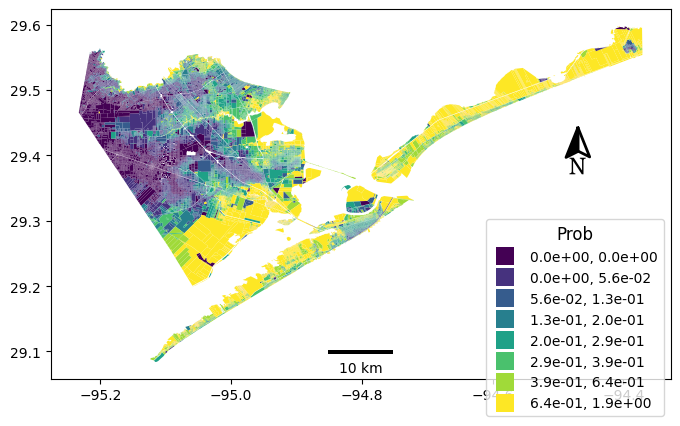

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
#Geodata0_random_count['VAL19IMP_int']  = np.round(Geodata0_random_count['VAL19IMP'] / 1000 )
Geodata.plot( column = 'Risk', 
                            scheme = "Quantiles", k = 8,
                            #scheme="user_defined", k = 8,
                #classification_kwds={'bins':[ 1,2,4, 6, 8, 10, 12]},
                            legend=True,
                           # legend_labels=legend_labels,
                            ax = ax, cmap = 'viridis',     
                            edgecolor = "gray",  # Borderline color
                            linewidth = 0.0 ,
                            legend_kwds = {'loc':'upper right', 
                                            'bbox_to_anchor':(1.0, 0.45), 
                                            'fmt':'{:.1e}',
                                            'markerscale':1.26, 
                                            'title_fontsize':'large', 
                                            'fontsize':'medium'}
                            )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("Prob")
# Set markers to square shape
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()

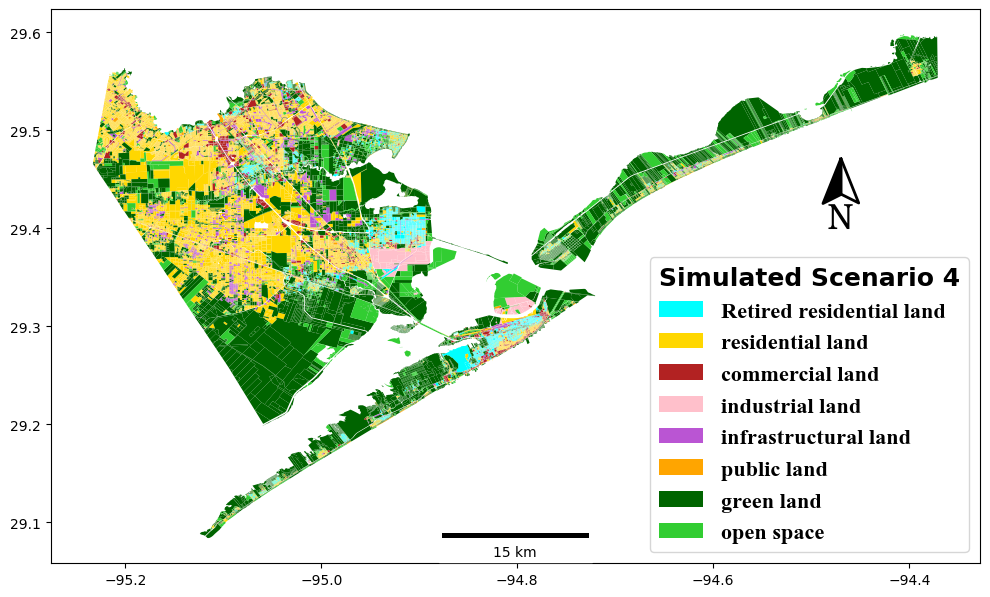

In [116]:
#fp = "../inputs/gis_data/Parcel_output_sce3.shp"
##Geodata = gpd.read_file(fp)
#read_start          = time.process_time()
#Geodata             = read_dataframe( fp )
#read_end            = time.process_time()
#Geodata      = Geodata.to_crs({'init':'epsg:4326'})

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUC3'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))
#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="Simulated Scenario 4",
            title_fontsize='xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon=True )
leg._legend_box.align = "left"

legend = ax.get_legend()
legend.set_title( "Simulated Scenario 4" , prop={'size' : 18, 'weight':'bold'})
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/LandUse_test4_2.png', dpi = 900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/LandUse_test4_2.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [117]:
#Geodata['LUC3'] = Geodata['ReviLUC3']
Geodata_select = gpd.GeoDataFrame( Geodata , geometry = 'geometry', crs="EPSG:4326")
write_dataframe(Geodata_select, path= r'../inputs/gis_data/Parcel_output_sce3.shp',
                        driver='ESRI Shapefile')

In [257]:
Geodata_select.columns
#( Geodata.loc[( Geodata["LUC3"] > 0 ) & (Geodata["LUC3"] < 6), 'pararea'].sum() - Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6), 'pararea'].sum() ) 

Index(['index', 'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE',
       'landCode', 'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode',
       'waterclass', 'watername', 'parkigcode', 'parkigclas', 'LUCode01re',
       'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode',
       'policyCost', 'policyCoun', 'elevationN', 'Content_Bu', 'ACRES',
       'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'NumStories', 'Foundation',
       'FirstFloor', 'ContentCos', 'BldgDamage', 'CDDF_ID', 'YEARBUILT',
       'Tract', 'Insurance', 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
       'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority',
       'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist',
       'CoastDist', 'WetlatDist', 'floodzones', 'buildDEM', 'PArea',
       'slope_mhw', 'logAccess', 'area_2', 'pararea', 'Risk', 'NN1', 'NN2',
       'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2', 'WaterCoast',
       'predprobs', 'predLU', 'cate1d

In [741]:
print( Geodata.LUCprob.quantile([0.1, 0.25, 0.5, 0.75]) )

print( Geodata.predprobs.min() )

0.10   -1.0
0.25   -1.0
0.50   -1.0
0.75   -1.0
Name: LUCprob, dtype: float64
5e-15


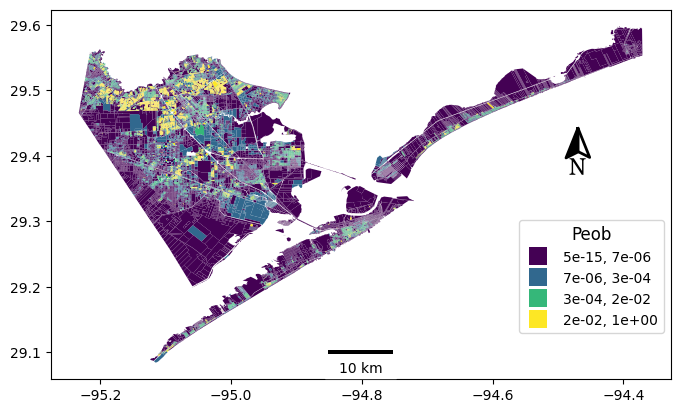

In [744]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)

#Geodata0_random_count['VAL19IMP_int']  = np.round(Geodata0_random_count['VAL19IMP'] / 1000 )
Geodata.plot( column = 'predprobs', 
                            #scheme = "Quantiles", k = 10,
                            scheme="user_defined", k = 4,
                classification_kwds={'bins':[ 6.55*10**(-6), 2.67*10**(-4), 0.0213]},
                            legend=True,
                           # legend_labels=legend_labels,
                            ax = ax, cmap = 'viridis',     
                            edgecolor = "gray",  # Borderline color
                            linewidth = 0.0 ,
                            legend_kwds = {'loc':'upper right', 
                                            'bbox_to_anchor':(1.0, 0.45), 
                                            'fmt':'{:.0e}',
                                            'markerscale':1.26, 
                                            'title_fontsize':'large', 
                                            'fontsize':'medium'}
                            )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("Prob")
# Set markers to square shape
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()

# Scenario 4 Simulation

In [75]:
fp = "../inputs/gis_data/Parcel_input_sce4.shp"
#Geodata = gpd.read_file(fp)
read_start   = time.process_time()
Geodata      = read_dataframe( fp )
read_end     = time.process_time()
Geodata      = Geodata.to_crs({'init':'epsg:4326'})


In [76]:
Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
Geodata["LUC4"]      = Geodata['LUCode20re']
#Geodata["Year4"]    = Geodata['YEARBUILT'] ############
Geodata["Year4"]      = Geodata.apply(lambda x: x['YEARBUILT'] if x['VAL19IMP'] > 0 else 0 , axis=1) ############
Geodata["Year4"]      = Geodata.apply(lambda x: randint(1980, 2020) if x['VAL19IMP'] > 0 and x['Year4'] == 0 else 0 , axis=1) ############

Geodata_dict = Geodata.to_dict('records')
def_value = 0
predYrs             = 2050
deltaY = 5
initialYrs          = 2020
ResidentialGrowth = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                                         (Geodata["LUCode20re"] < 6), "pararea" ]) - 
                     np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                                         (Geodata["LUCode11re"] < 6), "pararea" ]) )
print("ResidentialGrowth ", ResidentialGrowth)
#ResidentialGrowth = 39883108.19182694
predyears = range(initialYrs, predYrs+1, 1) 
print( "Number of steps {}".format( len(predyears) ) )
LandGrowth        = np.round( ResidentialGrowth *1.0 * deltaY / 10)
print("LandGrowth ", LandGrowth)
Geodata['LANDUSE'] = Geodata['LANDUSE'].fillna('')
#Geodata_dict = Geodata.to_dict('records')

DatamagEstimator       = DepthDamage( DamageFunc1, DamageFunc2, DamageFunc3)
modelreplication       = 1


Rand_uniform = pd.read_csv( '../outputs/Rand_unifor_df.csv', encoding='utf-8')
rand_unif = np.array( Rand_uniform )
len(rand_unif[0])


ResidentialGrowth  57174649.62915
Number of steps 31
LandGrowth  28587325.0
Finish read data second part


30

In [25]:
Geodata.columns

Index(['index', 'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE',
       'landCode', 'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode',
       'waterclass', 'watername', 'parkigcode', 'parkigclas', 'LUCode01re',
       'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode',
       'policyCost', 'policyCoun', 'elevationN', 'Content_Bu', 'ACRES',
       'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'NumStories', 'Foundation',
       'FirstFloor', 'ContentCos', 'BldgDamage', 'CDDF_ID', 'YEARBUILT',
       'Tract', 'Insurance', 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
       'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority',
       'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist',
       'CoastDist', 'WetlatDist', 'floodzones', 'buildDEM', 'H_ft', 'PArea',
       'slope_mhw', 'logAccess', 'area_2', 'pararea', 'Risk', 'NN1', 'NN2',
       'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2', 'WaterCoast',
       'predprobs', 'predLU',

<Axes: >

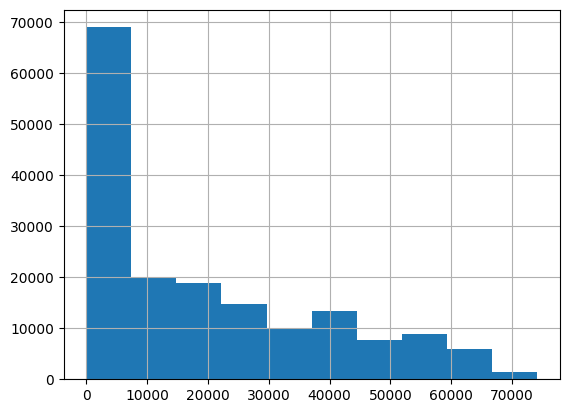

In [197]:

#Geodata.loc[Geodata['floodzones'].isin([3, 5, 6, 8]) ].CoastDist.hist()
Geodata.CoastDist.hist()

In [87]:
'''
results_risk2 = []
for rowi0 in Geodata.itertuples():
    risk_test = DatamagEstimator.RiskCalculation( rowi0.FirstFloor , rowi0.floodzones, 
                                 2030, 2060, rowi0.WaterCoast, 0.1403)
    #print( "Results are {}, {}, {}".format(rowi.floodzones, rowi.WaterCoast, risk_test) )
    results_risk2.append(risk_test)
plt.hist(results_risk2)
'''


In [198]:

rand_heights = ( 1995.194 - 1 * np.log( -1 * np.log( rand_unif ) ) * 304.512  ) / 304.8
rand_heights[2]

array([5.13982754, 6.45105085, 7.55702493, 6.25514138, 6.3273134 ,
       6.12392349, 7.24255523, 7.00944062, 9.20321495, 7.8914658 ,
       7.9261274 , 8.03447266, 6.5790443 , 7.20834322, 6.94922467,
       8.95636037, 8.52726829, 6.90803183, 7.15741486, 5.22786174,
       6.42881066, 8.60917134, 7.25340148, 7.8960978 , 5.4552636 ,
       6.27573675, 7.82163912, 6.57407061, 7.59139308, 7.15568933])

In [77]:
ncolumns        = len( predyears )
total_parcel_N  = len( Geodata )
improvedValues  = np.zeros( total_parcel_N ) 
changes         = np.zeros( total_parcel_N ) 
impvi_b0        = np.random.normal(159961.40, 2543.65, size = total_parcel_N)
impvi_b1        = np.random.normal(158.84, 55.61, size = total_parcel_N)
slrH            = 0
para_b          = 0.000003
year0           = predyears[ 0 ] ############
year1           = predyears[ 0 ] + deltaY ############
parcelgrowth    = []
for yith in range( ncolumns ):
    #heighti  = rand_heights[i, yith] #feet
    yeark    = predyears[ yith ]
    if yeark % 5 == 0:
        print( "Simulation Year {}".format( yeark ) )
    if yith >= 1 and para_b > 0:
        rate = ( 0.0017*( yeark ) + para_b*( ( yeark )** 2) ) - ( 0.0017*( yeark -1) + para_b*( ( yeark -1) ** 2) )
    else:
        rate = 0 
    slrH     = ( slrH + rate ) 
    slrHmm   = slrH * 1000
    sigmai   = 304.512
    mui      = 1995.194 + slrHmm 
    distchange = dem_waterdist( ( slrHmm ) / 304.8 ) 
    """" update probs from gbdt"""
    LandGrowth_agg    = np.round( LandGrowth) 
    totalDamage_i     = 0
    if yeark  % deltaY == 0 and yeark > initialYrs:
        print("************Before***************")
        print( "LUCode20re {}".format( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  ) )
        print( "LUC4 {} and Land growth {}".format( Geodata.loc[( Geodata["LUC4"] > 0 ) & (Geodata["LUC4"] < 6)].pararea.sum(),  LandGrowth_agg  ) )
        landuseProb   = np.zeros( total_parcel_N ) 
        landuselist   = np.zeros( total_parcel_N ) 
        NeighbiorLU   = np.zeros( total_parcel_N ) 
        landuseType   = np.zeros( total_parcel_N ) 
        idx_parcel    = 0
        Geodata_dict  = Geodata.to_dict('records')
        for rowi in Geodata_dict:
            #logdisti = np.log( rowi['WaterCoast'] - distchange ) if rowi['WaterCoast'] > distchange else 0
            waterdisti = rowi['WaterCoast'] - distchange if rowi['WaterCoast'] > distchange else 0
            if yeark % (deltaY*2) == 0 :
                #if rowi['TARGET_FID'] == 73463 or rowi['TARGET_FID'] == 34357 or rowi['TARGET_FID'] == 96428:
                #    print("{} Before update risk {}".format( rowi['TARGET_FID'], rowi['Risk'] ) )
                cates_hi = np.array( [  rowi['cate1diff'], rowi['cate2diff'], rowi['cate3diff'], 
                                    rowi['cate4diff'], rowi['cate5diff'] ]) 
                risk_test = DatamagEstimator.RiskCalculation( FirstFloor = rowi['FirstFloor'], 
                                                            floodzones = rowi['floodzones'], 
                                                            y_from = yeark, y_end= yeark + 30, 
                                                            waterdist = waterdisti, 
                                                            dem = rowi['DEM'],
                                                            cate_diffs = cates_hi, slrH = slrH)
                Geodata.at[ rowi['TARGET_FID'], 'Risk' ]   = risk_test
                rowi['Risk']                               = risk_test

            #print( "Year ",yith  )
            if rowi['LUC4']  <= 0 :
                improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                landuseType[ idx_parcel]       = 0
                landuseProb[ idx_parcel]       = 0.0
                #CoastDist
            elif ( rowi['floodzones'] in [3,5, 6, 8, 10]  ) :
                #if rowi['TARGET_FID'] == 73463 or rowi['TARGET_FID'] == 34357 or rowi['TARGET_FID'] == 96428:
                #    print( "{} After update risk {}".format( rowi['TARGET_FID'], rowi['Risk'] ) )
                #+ rowi["Insurance"] * 22.8
                if ( ( rowi['Risk']*rowi['VAL19TOT'] + rowi["Insurance"] * 22.8 )
                    > rowi['VAL19TOT'] and rowi['LUC4'] > 0 and rowi['LUC4'] <= 5 ):
                    #landuseProb[ idx_parcel]       = 0.0
                    #improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                    #landuseType[ idx_parcel]       = 0
                    #LandGrowth_agg = LandGrowth_agg + rowi['pararea']
                    Geodata.at[ rowi['TARGET_FID'], 'LUC4' ]   = 0  
                    Geodata.at[ rowi['TARGET_FID'], 'Year4' ] = randint(year0, year1)
                    #print( " buyout land " )
                #else:
                    #print( "No buyout land " )
            #landuselist[ idx_parcel ] = rowi['LUC2']  
            if rowi['floodzones'] in [3, 5, 6, 8, 10]:
                landuseProb[ idx_parcel]      +=  -1.0
                landuseType[ idx_parcel]       =  rowi['LUC4'] 
                improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
            elif rowi['LUC4']   <= 5 and rowi['LUC4'] >= 0 and rowi['VAL19IMP'] > 0:
                landuseProb[ idx_parcel]      +=  -1.0
                landuseType[ idx_parcel]       =  rowi['LUC4'] 
                improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                #if rowi['LUC2'] > 0 and rowi['LUC2'] < 5:
                #    print("??? LU developed ", rowi['LUC2'], row['VAL19IMP'], row['LANDUSE'])
            elif "UW" in rowi['LANDUSE'] or rowi['LANDUSE'] == 0 :
                landuseProb[ idx_parcel]       += -1.0 
                improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                landuseType[ idx_parcel]       = 0
                rowi['LUC4']                   = 0
            elif (rowi['poicode'] == 2204 or rowi['poicode'] == 2082 or 
                    rowi['poicode'] == 2081) :
                landuseProb[ idx_parcel]       = 0.0
                landuseType[ idx_parcel]       = rowi['LUCode11re']  
                improvedValues[ idx_parcel]    = rowi['VAL19IMP'] 
            elif rowi['parkigcode'] > 0 or rowi['watercode'] > 0 :
                landuseProb[ idx_parcel]       = 0.0 
                improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                landuseType[ idx_parcel]       =  rowi['LUC4'] 
            elif rowi['LUC4']   != rowi['LUCode20re'] :
                landuseProb[idx_parcel]       +=  -1.0 
                landuseType[ idx_parcel]       =  rowi['LUC4'] 
                improvedValues[ idx_parcel]    =  rowi['VAL19IMP']     
            else:
                #if rowi['LUC4'] > 0 and rowi['LUC4'] < 5 and rowi['VAL19IMP'] <= 0:
                #    print("Error LU developed ", rowi['LUC4'], rowi['VAL19IMP'], rowi['LUCode20re'])
                urban_neighbor_probs = neghbor_prob( rowi['TARGET_FID'], Geodata, 'LUC4')
                maxlu         = rowi['predLU']
                if maxlu == urban_neighbor_probs[1] + 1 and maxlu == rowi['LUCode'] :
                    landuseType[ idx_parcel]       =  maxlu
                    landuseProb[ idx_parcel]  = rowi['predprobs']
                elif urban_neighbor_probs[1] + 1 ==  rowi['LUCode']:
                    landuseType[ idx_parcel]  =  urban_neighbor_probs[1] + 1
                    landuseProb[ idx_parcel]  = urban_neighbor_probs[0]
                else:
                    landuseType[ idx_parcel]  = maxlu
                    landuseProb[ idx_parcel]  = rowi['predprobs']
                #landuseProb[ idx_parcel]  = rowi['predprobs']
                #landuseType[ idx_parcel]       =  maxlu
                #impvi = impvi_b0[ idx_parcel] +\
                #        impvi_b1[ idx_parcel] * rowi["pararea"]                 
                improvedValues[ idx_parcel]    =  rowi['VAL19IMP']  
            idx_parcel = idx_parcel + 1
            
        Geodata["LUCprob"]  = landuseProb
        Geodata["LUCtype"]  = landuseType
        Geodata["ImproVal"] = improvedValues    
        #Geodata["LUC2"]     = landuselist
        Geodata.sort_values("LUCprob", ascending = False, inplace = True)
        Geodata["rank"]     = Geodata.reset_index().index + 1
        Geodata["PAreaCum"] = Geodata["pararea"].cumsum()
        lengthi             = Geodata["PAreaCum"].searchsorted( LandGrowth_agg, side='right') + 1
        print( "length of pararea", lengthi )
        temnlu              = len( Geodata.loc[( Geodata["LUC4"] > 0 ) & (Geodata["LUC4"] < 6)] )
        results1 = []
        results2 = []
        Geodata_dict2  = Geodata.to_dict('records')
        count_rank = 0
        for rowi2 in Geodata_dict2:
            if rowi2["rank"] < lengthi:
                Geodata.at[ rowi2['index'], 'LUC4' ] = rowi2['LUCtype']
                Geodata.at[ rowi2['index'], 'Year4' ] = randint(year0, year1)
                if rowi2['index'] != Geodata.at[ rowi2['index'], 'index' ]:
                    print("Error", Geodata.at[ rowi2['index'], 'index' ], " ", rowi2['index'])   
                if rowi2['LUC4'] <= 5 and rowi2['LUC4'] >= 1 and rowi2['ImproVal'] == 0:
                    impvi = impvi_b0[ count_rank] +\
                            impvi_b1[ count_rank] * rowi2['pararea'] 
                    
                    Geodata.at[ rowi2['index'], 'VAL19IMP' ] = impvi
                else:
                    Geodata.at[ rowi2['index'], 'VAL19IMP' ] = rowi2['ImproVal']
            else:
                if rowi2['LUCtype'] == 0:
                    Geodata.at[ rowi2['index'], 'LUC4' ] =  rowi2['LUCtype']
                    #Geodata.at[ rowi2.Index, 'VAL19IMP' ] = 
                #Geodata.at[ rowi2.Index, 'VAL19IMP' ] = rowi2.ImproVal
            count_rank = count_rank + 1 
        year0 = yeark
        year1 = yeark + deltaY
        #Geodata.loc[ Geodata["rank"] < lengthi, "LUC2"]      = Geodata.loc[ Geodata["rank"] < lengthi, "LUCtype"]
        #Geodata.loc[ Geodata["rank"] < lengthi, "VAL19IMP"] = Geodata.loc[ Geodata["rank"] < lengthi, "ImproVal"]
        #Geodata['LUC4']      = results1
        #Geodata['VAL19IMP']  = results2
        #Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
        change_parcel_yeari =len( Geodata.loc[( Geodata["LUC4"] > 0 ) & (Geodata["LUC4"] < 6)] ) - temnlu
        print("************After***************")
        print("From ", year0, " to ", year1, "# parcels diff ", change_parcel_yeari )
        parcelgrowth.append( change_parcel_yeari )
print( "Output LU20 {}".format( Geodata.loc[( Geodata["LUCode20re"] > 0 ) & (Geodata["LUCode20re"] < 6)].pararea.sum()  ) )
print( "Output LUC4 {}".format( Geodata.loc[( Geodata["LUC4"] > 0 ) & (Geodata["LUC4"] < 6)].pararea.sum(), " ", LandGrowth_agg  ) )

Simulation Year 2020
Simulation Year 2025
************Before***************
LUCode20re 257568690.85302788
LUC4 257568690.85302788 and Land growth 28587325.0
length of pararea 7226
************After***************
From  2025  to  2030 # parcels diff  1896
Simulation Year 2030
************Before***************
LUCode20re 257568690.8530279
LUC4 242861753.37147802 and Land growth 28587325.0
length of pararea 4885
************After***************
From  2030  to  2035 # parcels diff  2651
Simulation Year 2035
************Before***************
LUCode20re 257568690.85302788
LUC4 253157568.926818 and Land growth 28587325.0
length of pararea 1197
************After***************
From  2035  to  2040 # parcels diff  666
Simulation Year 2040
************Before***************
LUCode20re 257568690.8530279
LUC4 279565976.67331797 and Land growth 28587325.0
length of pararea 1323
************After***************
From  2040  to  2045 # parcels diff  857
Simulation Year 2045
************Before**********

In [81]:
parcelgrowth

[1896, 2651, 666, 857, 900, 680]

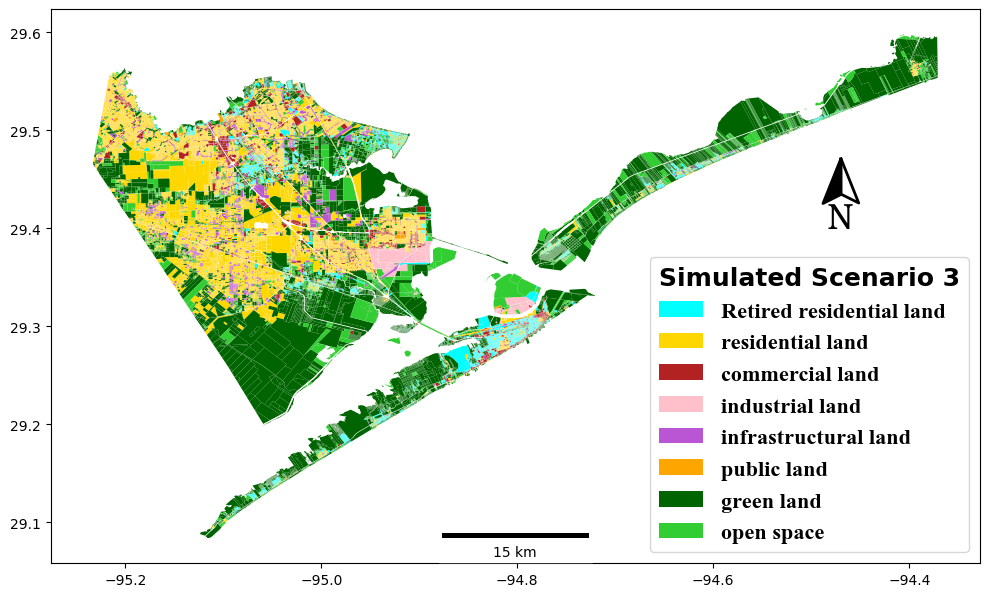

In [79]:

#fp = "../inputs/gis_data/Parcel_output_sce4.shp"
##Geodata = gpd.read_file(fp)
#read_start          = time.process_time()
#Geodata             = read_dataframe( fp )
#read_end            = time.process_time()
#Geodata      = Geodata.to_crs({'init':'epsg:4326'})

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUC4'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="Simulated Scenario 3",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Simulated Scenario 3" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()

#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)

plt.tight_layout()

#plt.savefig('../output_images/LandUse_test3_2.png',dpi=900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/LandUse_test3_2.pdf', bbox_inches='tight', pad_inches=0)

plt.show()


In [80]:
Geodata_select = gpd.GeoDataFrame( Geodata , geometry = 'geometry', crs="EPSG:4326")
write_dataframe(Geodata_select, path= r'../inputs/gis_data/Parcel_output_sce4.shp',
                        driver='ESRI Shapefile')


In [55]:
print( Geodata.Year4.value_counts() )
# 0 : 41666
print( Geodata.Year4.max(), yeark )
print(list(predyears))

Year4
0       33746
2020     8780
2025     7799
2024     6966
2022     6856
        ...  
2042      226
2033      216
2031      207
2032      206
2034      179
Name: count, Length: 72, dtype: int64
2050 2050
[2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]


In [58]:
parcelgrowth

[1896, 2651, 667, 887, 902, 658]

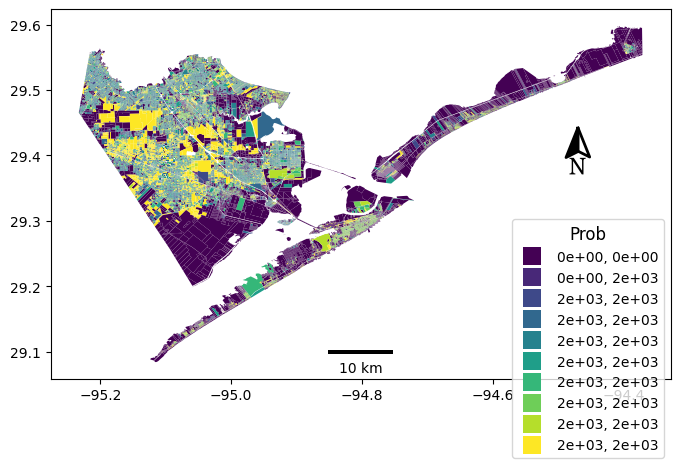

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
pmarks = []
divider = make_axes_locatable(ax)
#Geodata0_random_count['VAL19IMP_int']  = np.round(Geodata0_random_count['VAL19IMP'] / 1000 )
#CoastDist
#NEA_DIST2, NEAR_DIST area_2
Geodata.plot( column = 'Year4', 
                            scheme = "Quantiles", k = 10,
                            #scheme="user_defined", k = 4,
                #classification_kwds={'bins':[ 6.55*10**(-6), 2.67*10**(-4), 0.0213]},
                            legend=True,
                           # legend_labels=legend_labels,
                            ax = ax, cmap = 'viridis',     
                            edgecolor = "gray",  # Borderline color
                            linewidth = 0.0 ,
                            legend_kwds = {'loc':'upper right', 
                                            'bbox_to_anchor':(1.0, 0.45), 
                                            'fmt':'{:.0e}',
                                            'markerscale':1.26, 
                                            'title_fontsize':'large', 
                                            'fontsize':'medium'}
                            )
leg1 = ax.get_legend()
# Set markers to square shape
for ea in leg1.legendHandles:
    ea.set_marker('s')
leg1.set_title("Prob")
# Set markers to square shape
x, y, arrow_length = 0.85, 0.6, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)
ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction = 0.15) )
#ax.set_title('', fontsize= 28)
ax.set_axis_on()



# Plot stochastic damages

In [1162]:
fp1 = "../inputs/gis_data/Parcel_output_sce2.shp"
fp2 = "../inputs/gis_data/Parcel_output_sce4.shp"

Geodata2  = read_dataframe( fp1 )
print( Geodata2.LUC2.value_counts() )
Geodata4  = read_dataframe( fp2 )
print( Geodata4.LUC4.value_counts() )


LUC2
1    111533
0     23000
6     20811
2      5583
7      4669
4      3499
5       937
3       162
Name: count, dtype: int64
LUC4
1    104160
0     28249
6     22765
2      5320
7      5135
4      3496
5       894
3       175
Name: count, dtype: int64


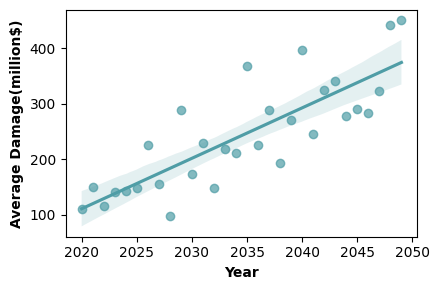

In [259]:
input_files   = [ 'sce1', 'sce2', 'sce3', 'sce4' ]

output_years  = [ 'Year', 'Year2', 'Year3', 'Year4' ]
output_landns = [ 'LUC1', 'LUC2', 'LUC3', 'LUC4']
output_names  = [ 'Scenario1', 'Scenario2', 'Scenario4', 'Scenario3']
output_color  = [ (26/255.0, 8/255.0, 65/255.0), 
                  (79/255.0, 157/255.0, 166/255.0), 
                  (255/255.0, 173/255.0, 90/255.0), 
                  (255/255.0, 89/255.0, 89/255.0) ]

fig, ax = plt.subplots(figsize=(4.5, 3))
slope, intercept, r_value, p_value, std_err = stats.linregress(aggregate_total['Year'] - 2020,
                                                            aggregate_total['total_damage'] )
p = sns.regplot( data= aggregate_total, 
            x = "Year", y = "total_damage", ax = ax, 
            scatter_kws={"color": rgb2hex( output_color[out_idx] ), 'alpha':0.7}, 
line_kws={"color":  rgb2hex( output_color[out_idx] ) , 'alpha': 1, } )
#'label':"y={0:.3f}x+{1:.1f}".format(slope, intercept)
legend_handles, _= p.get_legend_handles_labels()
#p.legend(legend_handles, ['Average damage ($)'],bbox_to_anchor=(0.9, 0.2))
p.set(xlabel='Year', ylabel='Average Damage(million$)')
p.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
p.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
plt.tight_layout()
plt.savefig( fig_pthi, dpi= 900, bbox_inches='tight', pad_inches=0)
plt.show()


../inputs/gis_data/Parcel_output_sce3.shp
Replication 0
Replication 20
Replication 40
Replication 60
Replication 80


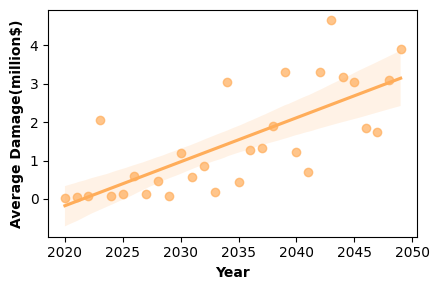

In [5]:
input_files   = [ 'sce1', 'sce2', 'sce3', 'sce4' ]
output_years  = [ 'Year', 'Year2', 'Year3', 'Year4' ]
output_landns = [ 'LUC', 'LUC2', 'LUC3', 'LUC4']
output_names  = [ 'Scenario1', 'Scenario2', 'Scenario4', 'Scenario3']
output_color  = [ (26/255.0, 8/255.0, 65/255.0), 
                  (79/255.0, 157/255.0, 166/255.0), 
                  (255/255.0, 173/255.0, 90/255.0), 
                  (255/255.0, 89/255.0, 89/255.0) ]
#input_files   = [ 'sce2', 'sce3', 'sce4' ]

input_files   = [ 'sce3' ]
output_years  = [ 'Year3' ]
output_landns = [ 'LUC3']
output_names  = [ 'Scenario4']
output_color  = [ (255/255.0, 173/255.0, 90/255.0) ]

#input_files   = [ 'sce1', 'sce2' ]
for out_idx in range(len(input_files)):
    out_fi      = input_files[out_idx]
    landnamei   = output_landns[out_idx]
    yeari   = output_years[out_idx]
    fpi = "../inputs/gis_data/Parcel_output_{}.shp".format( out_fi )
    print(fpi)
    #Geodata = gpd.read_file(fp)
    read_start          = time.process_time()
    Geodata             = read_dataframe( fpi )
    read_end            = time.process_time()
    Geodata      = Geodata.to_crs({'init':'epsg:4326'})
    #Rand_uniform = pd.read_csv( '../outputs/Rand_unifor_df.csv', encoding='utf-8')
    #rand_unif = np.array( Rand_uniform )
    
    rand_unif = stats.uniform.rvs(loc= 0, scale= 1, 
                              size= ( 100, 30 ) )
    len(rand_unif[0])
    ncolumns        = len( rand_unif[0] )
    nrows           = len( rand_unif )
    total_parcel_N  = len( Geodata )
    improvedValues  = np.zeros( total_parcel_N ) 
    changes         = np.zeros( total_parcel_N ) 
    probLoss        = np.zeros( total_parcel_N ) 
    LossPercent     = np.zeros( ( nrows, total_parcel_N ) ) 
    RelocateFull    = np.zeros( ( nrows, total_parcel_N ) ) 

    damage_count_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
    ploss_count_dict  = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
    damage_perct_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)


    predYrs             = 2050
    deltaY = 5
    initialYrs          = 2020
    predyears = range(initialYrs, predYrs, 1) 
    Aggregate_Year                  = pd.DataFrame()
    Aggregate_Year["Year"]          = predyears
    aggregate_damage_dict2 = dict.fromkeys( Aggregate_Year.Year.to_list() , 0)

    impvi_b0        = np.random.normal(159961.40, 2543.65, size = total_parcel_N)
    impvi_b1        = np.random.normal(158.84, 55.61, size = total_parcel_N)
    slrH            = 0
    para_b          = 0.000003
    Geodata_dict  = Geodata.to_dict('records')
    for i in range( nrows  ):
        slrH = 0
        damage_count_dict = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
        ploss_count_dict  = dict.fromkeys( Geodata.TARGET_FID.to_list() , 0)
        if i % 20 == 0:
            print( "Replication {}".format( i ) )
        #Geodata["VALIMP"]    = Geodata['VAL19IMP']
        #Geodata_dict  = Geodata.to_dict('records')
        relocate_count1 = 0
        relocate_count2 = 0
        for yith in range( ncolumns ):
            probi    = rand_unif[i, yith]
            yeark    = predyears[ yith ]
            if yith >= 1 and para_b > 0:
                rate = ( 0.0017*( yeark ) + para_b*( ( yeark )** 2) ) - ( 0.0017*( yeark -1) + para_b*( (yeark -1) ** 2) )
            else:
                rate = 0 
            slrH     = (slrH + rate ) 
            slrHmm   = slrH * 1000;
            sigmai   = 304.512
            mui      = 1995.194 + slrHmm
            heighti  = ( mui - 1 * np.log( -1 * np.log( probi ) ) * sigmai ) /304.8
            distchange = dem_waterdist( ( slrHmm ) / 304.8 ) 
            """" update probs from gbdt"""
            totalDamage_i  = 0
            idx_parcel            =  0
            #Geodata_dict = Geodata.to_dict('records')
            for rowi in Geodata_dict:
                if rowi['DEM'] < heighti and rowi['DEM'] > 0:
                    floodhi  = heighti - rowi['DEM']  
                elif rowi['DEM'] < 0 :
                    floodhi  = heighti
                else:
                    floodhi  = 0
                logdisti = np.log( rowi['WaterCoast'] - distchange ) if rowi['WaterCoast'] > distchange else 0
                if floodhi > 0 and rowi["VAL19IMP"] > 0:
                    if rowi['Cate5'] > 0:
                        floodi0  = floodh_adjust( 1 - probi, floodhi, logdisti )
                    else:
                        floodi0  = floodhi
                    catediffi = np.array( [ rowi['cate1diff'] , rowi['cate2diff'] , 
                                            rowi['cate3diff'] , rowi['cate4diff'] , 
                                            rowi['cate5diff'] ] )
                    floodi  = floodh_catediff( floodi0, catediffi, 1 - probi )
                    if rowi['FirstFloor'] > 3:
                        ffh = rowi['FirstFloor'] - 1
                    else:
                        ffh = rowi['FirstFloor']
                    Damagei = DatamagEstimator.damage_heighti( floodhi, 
                                                            ffh , 
                                                            rowi['floodzones'] )
                else:
                    floodi  = 0.0
                    Damagei = 0.0
                if Damagei > 0 and rowi[ landnamei ] > 0 and rowi[ landnamei ] <= 5 and rowi[yeari] > 1 and rowi[yeari] < yeark:
                    if Damagei > 0.1:
                        ploss_count_dict[ rowi['TARGET_FID'] ] = ploss_count_dict[ rowi['TARGET_FID'] ] + 1
                    damage_perct_dict[ rowi['TARGET_FID'] ] = damage_perct_dict[ rowi['TARGET_FID'] ] + Damagei * rowi['VAL19TOT']
                    if ploss_count_dict[ rowi['TARGET_FID'] ] >= 2 and rowi[ landnamei ] > 0 and rowi[ landnamei ] <= 5 and rowi['VAL19IMP'] > 10000:
                        RelocateFull[i, idx_parcel] = 1
                    LossPercent[i, idx_parcel] = Damagei
                    totalDamage_i = totalDamage_i + Damagei * rowi['VAL19TOT']
                idx_parcel = idx_parcel + 1
            aggregate_damage_dict2[ yeark ] = aggregate_damage_dict2[ yeark ] + totalDamage_i
    
    #print( "Year ", yeark," urban land", len( Geodata.loc[ ( Geodata[yeari] > 1 & Geodata[yeari] < yeark) ] ) )
    aggregate_total = pd.DataFrame( aggregate_damage_dict2.items() ) 
    aggregate_total.columns = [ "Year", "total_damage" ]
    aggregate_total["total_damage"] = aggregate_total["total_damage"] *1.0/ len( rand_unif ) / 1e6
    opti = '../outputs/Year_Damage_{}.csv'.format( output_names[out_idx] )
    aggregate_total.to_csv( opti, index=False)

    fig_pthi = '../output_images/Damage_{}_2.png'.format( output_names[out_idx] )
    fig, ax = plt.subplots(figsize=(4.5, 3))
    slope, intercept, r_value, p_value, std_err = stats.linregress(aggregate_total['Year'] - 2020,
                                                                aggregate_total['total_damage'] )
    p = sns.regplot( data= aggregate_total, 
                x = "Year", y = "total_damage", ax = ax, 
                scatter_kws={"color": rgb2hex(output_color[out_idx]), 'alpha':0.7}, 
    line_kws={"color": rgb2hex(output_color[out_idx]), 'alpha': 1, } )
    #'label':"y={0:.3f}x+{1:.1f}".format(slope, intercept)
    legend_handles, _= p.get_legend_handles_labels()
    #p.legend(legend_handles, ['Average damage ($)'],bbox_to_anchor=(0.9, 0.2))
    p.set(xlabel='Year', ylabel='Average Damage(million$)')
    p.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
    p.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
    plt.tight_layout()
    plt.savefig( fig_pthi, dpi= 900, bbox_inches='tight', pad_inches=0)
    plt.show()

    

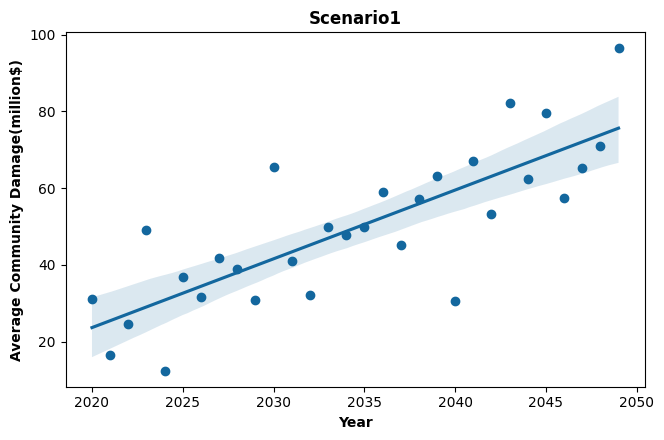

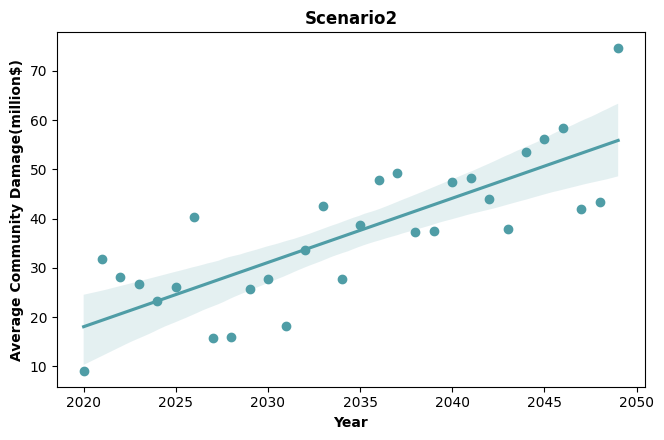

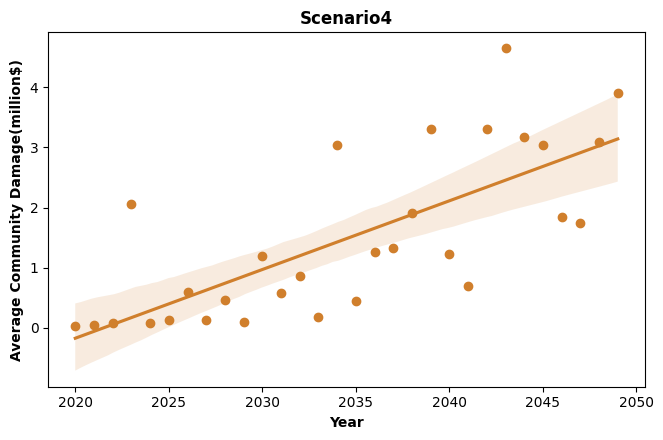

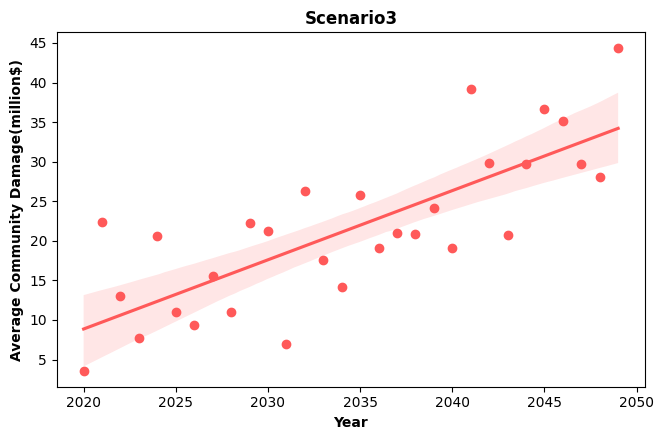

In [6]:
output_names  = [ 'Scenario1', 'Scenario2', 'Scenario4', 'Scenario3']
output_color  = [ (19/255.0, 103/255.0, 158/255.0) ,
                   (79/255.0, 157/255.0, 166/255.0), 
                  (208/255.0, 127/255.0, 44/255.0), 
                  (255/255.0, 89/255.0, 89/255.0)
                  ]
for out_idx in range(len(output_names)):
    opti = '../outputs/Year_Damage_{}.csv'.format( output_names[out_idx] )
    aggregate_total = pd.read_csv( opti, encoding='utf-8')
    fig_pthi = '../output_images/Damage_{}_2.pdf'.format( output_names[out_idx] )
    fig, ax = plt.subplots(figsize=(6.75, 4.5))
    slope, intercept, r_value, p_value, std_err = stats.linregress(aggregate_total['Year'] - 2020,
                                                                aggregate_total['total_damage'] )
    p = sns.regplot( data= aggregate_total, 
                x = "Year", y = "total_damage", ax = ax, 
                scatter_kws={"color": rgb2hex(output_color[out_idx]), 'alpha': 1}, 
    line_kws={"color": rgb2hex(output_color[out_idx]), 'alpha': 1.0, } )
    #'label':"y={0:.3f}x+{1:.1f}".format(slope, intercept)
    p.set_title( output_names[out_idx] , fontdict={'weight': 'bold'})
    legend_handles, _= p.get_legend_handles_labels()
    #p.legend(legend_handles, ['Average damage ($)'],bbox_to_anchor=(0.9, 0.2))
    p.set(xlabel='Year', ylabel='Average Community Damage(million$)')
    p.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
    p.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
    plt.tight_layout()
    #plt.savefig( fig_pthi, dpi= 900, bbox_inches='tight', pad_inches=0)
    plt.savefig( fig_pthi, bbox_inches='tight', pad_inches=0)
    plt.show()


<Axes: >

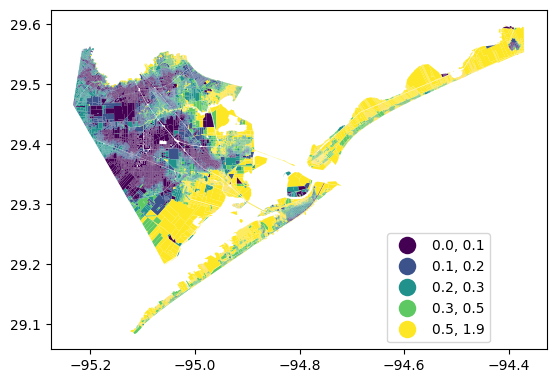

In [169]:
Geodata.plot(column= 'Risk', 
             scheme="Quantiles", k = 5,
            #scheme = "user_defined", k = 5,
            #classification_kwds = {'bins':[0, 1, 2, 12]},
             legend = True, linewidth = 0.0,
             legend_kwds = { 'loc':'lower right', 
                            'bbox_to_anchor':(0.9, 0.0), 
                            'fmt':'{:.1f}',
                            'markerscale': 1.26, 
                            'title_fontsize':'large', 
                            'fontsize':'medium'} )


In [14]:
fp1 = "../inputs/gis_data/Parcel_output_sce1.shp"
fp2 = "../inputs/gis_data/Parcel_output_sce2.shp"
fp3 = "../inputs/gis_data/Parcel_output_sce3.shp"
fp4 = "../inputs/gis_data/Parcel_output_sce4.shp"
Geodata1             = read_dataframe( fp1 )
Geodata2             = read_dataframe( fp2 )
Geodata3             = read_dataframe( fp3 )
Geodata4             = read_dataframe( fp4 )


In [15]:
def countBuilding( row, luci, yearcatei ):
    if row[ luci ] == 0 :
        return 'retired'
    else:
        return row[ yearcatei ]

In [16]:

bins = [Geodata1['Year'].min()-1, 1, 2020, 2030, 2040, Geodata1['Year'].max() + 1]  # Adjust these values based on your data range
Geodata1['YearCat'] = pd.cut( Geodata1['Year'], bins, 
                               labels=['Not Built', 'Before 2020', '2020 - 2030',  '2030 - 2040',  '2040 - 2050' ] )
Geodata1['YearCat'] = Geodata1.apply(lambda x: countBuilding(x, 'LUC', 'YearCat'), axis = 1)
print( Geodata1['YearCat'].value_counts() )

print( "Before 2020 area", Geodata1.loc[ Geodata1['YearCat'] == 'Before 2020', 'pararea'].sum() *1e-6 )
print( "Notbuilt area", Geodata1.loc[ Geodata1['YearCat'] == 'Not Built', 'pararea'].sum()*1e-6 )
print( "Retired land area", Geodata1.loc[ Geodata1['YearCat'] == 'retired', 'pararea'].sum()*1e-6 )
print( "2020 - 2030 growth area", Geodata1.loc[ Geodata1['YearCat'] == '2020 - 2030', 'pararea'].sum() *1e-6)
print( "2030 - 2040 growth area", Geodata1.loc[ Geodata1['YearCat'] == '2030 - 2040', 'pararea'].sum() *1e-6)
print( "2040 - 2050 growth area", Geodata1.loc[ Geodata1['YearCat'] == '2040 - 2050', 'pararea'].sum() *1e-6)

print( "Retired costs", Geodata1.loc[ Geodata1['YearCat'] == 'retired', 'VAL19IMP'].sum()*1e-6 )


YearCat
Before 2020    100942
Not Built       50554
2020 - 2030     13260
2030 - 2040      3049
2040 - 2050      2191
retired           198
Name: count, dtype: int64
Before 2020 area 276.4982278928698
Notbuilt area 530.1025012771594
Retired land area 0.6327036277999999
2020 - 2030 growth area 64.10363042235
2030 - 2040 growth area 51.560624606710995
2040 - 2050 growth area 47.6617284064
Retired costs 2.779336


In [61]:
Geodata2.columns

Index(['index', 'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE',
       'landCode', 'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode',
       'waterclass', 'watername', 'parkigcode', 'parkigclas', 'LUCode01re',
       'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode',
       'policyCost', 'policyCoun', 'elevationN', 'Content_Bu', 'ACRES',
       'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'NumStories', 'Foundation',
       'FirstFloor', 'ContentCos', 'BldgDamage', 'CDDF_ID', 'YEARBUILT',
       'Tract', 'Insurance', 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
       'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority',
       'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist',
       'CoastDist', 'WetlatDist', 'floodzones', 'buildDEM', 'H_ft', 'PArea',
       'slope_mhw', 'logAccess', 'area_2', 'pararea', 'Risk', 'NN1', 'NN2',
       'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2', 'WaterCoast',
       'predprobs', 'predLU',

In [17]:

bins = [Geodata2['Year2'].min()-1, 1, 2020, 2030, 2040, Geodata2['Year2'].max() + 1]  # Adjust these values based on your data range
Geodata2['YearCat2'] = pd.cut( Geodata2['Year2'], bins, 
                               labels=['Not Built', 'Before 2020', '2020 - 2030',  '2030 - 2040',  '2040 - 2050' ] )
Geodata2['YearCat2'] = Geodata2.apply(lambda x: countBuilding(x, 'LUC2', 'YearCat2'), axis = 1)

print( Geodata2['YearCat2'].value_counts() )

print( "Before 2020 area", Geodata2.loc[ Geodata2['YearCat2'] == 'Before 2020', 'pararea'].sum() *1e-6 )
print( "Notbuilt area", Geodata2.loc[ Geodata2['YearCat2'] == 'Not Built', 'pararea'].sum()*1e-6 )
print( "Notbuilt area", Geodata2.loc[ Geodata2['LUC2'] > 5, 'pararea'].sum()*1e-6 )

print( "Retired land area", Geodata2.loc[ Geodata2['YearCat2'] == 'retired', 'pararea'].sum()*1e-6 )
print( "2020 - 2030 growth area", Geodata2.loc[ Geodata2['YearCat2'] == '2020 - 2030', 'pararea'].sum() *1e-6)
print( "2030 - 2040 growth area", Geodata2.loc[ Geodata2['YearCat2'] == '2030 - 2040', 'pararea'].sum() *1e-6)
print( "2040 - 2050 growth area", Geodata2.loc[ Geodata2['YearCat2'] == '2040 - 2050', 'pararea'].sum() *1e-6)

print( "Retired costs", Geodata2.loc[ Geodata2['YearCat2'] == 'retired', 'VAL19IMP'].sum()*1e-6 )


YearCat2
Before 2020    87309
Not Built      39583
retired        23695
2020 - 2030    13693
2030 - 2040     3075
2040 - 2050     2839
Name: count, dtype: int64
Before 2020 area 256.6019117902299
Notbuilt area 504.15169653955934
Notbuilt area 553.1132361505214
Retired land area 23.564325316399998
2020 - 2030 growth area 82.06745332699
2030 - 2040 growth area 55.409233298511
2040 - 2050 growth area 48.764795961599994
Retired costs 3143.661468


In [18]:
bins = [Geodata3['Year3'].min()-1, 1, 2020, 2030, 2040, Geodata3['Year3'].max() + 1]  # Adjust these values based on your data range
Geodata3['YearCat3'] = pd.cut( Geodata3['Year3'], bins, 
                               labels=['Not Built', 'Before 2020', '2020 - 2030',  '2030 - 2040',  '2040 - 2050' ] )
Geodata3['YearCat3'] = Geodata3.apply(lambda x: countBuilding(x, 'LUC3', 'YearCat3'), axis = 1)

print( Geodata3['YearCat3'].value_counts() )

print( "Before 2020 area", Geodata3.loc[ Geodata3['YearCat3'] == 'Before 2020', 'pararea'].sum() *1e-6 )
print( "Notbuilt area", Geodata3.loc[ Geodata3['YearCat3'] == 'Not Built', 'pararea'].sum()*1e-6 )
print( "Retired land area", Geodata3.loc[ Geodata3['YearCat3'] == 'retired', 'pararea'].sum()*1e-6 )
print( "2020 - 2030 growth area", Geodata3.loc[ Geodata3['YearCat3'] == '2020 - 2030', 'pararea'].sum() *1e-6)
print( "2030 - 2040 growth area", Geodata3.loc[ Geodata3['YearCat3'] == '2030 - 2040', 'pararea'].sum() *1e-6)
print( "2040 - 2050 growth area", Geodata3.loc[ Geodata3['YearCat3'] == '2040 - 2050', 'pararea'].sum() *1e-6)

print( "Retired costs", Geodata3.loc[ Geodata3['YearCat3'] == 'retired', 'VAL19IMP'].sum()*1e-6 )


YearCat3
Before 2020    78033
Not Built      41159
retired        34217
2020 - 2030    10845
2030 - 2040     4178
2040 - 2050     1762
Name: count, dtype: int64
Before 2020 area 245.22534225353002
Notbuilt area 521.5114297842393
Retired land area 41.08737747450989
2020 - 2030 growth area 58.39859324367001
2030 - 2040 growth area 59.954886232240995
2040 - 2050 growth area 44.38178724510001
Retired costs 5531.114683


In [19]:
bins = [Geodata4['Year4'].min()-1, 1, 2020, 2030, 2040, Geodata4['Year4'].max() + 1]  # Adjust these values based on your data range
Geodata4['YearCat4'] = pd.cut( Geodata4['Year4'], bins, 
                               labels=['Not Built', 'Before 2020', '2020 - 2030',  '2030 - 2040',  '2040 - 2050' ] )
Geodata4['YearCat4'] = Geodata4.apply(lambda x: countBuilding(x, 'LUC4', 'YearCat4'), axis = 1)

print( Geodata4['YearCat4'].value_counts() )

print( "Before 2020 area", Geodata4.loc[ Geodata4['YearCat4'] == 'Before 2020', 'pararea'].sum() *1e-6 )
print( "Notbuilt area", Geodata4.loc[ Geodata4['YearCat4'] == 'Not Built', 'pararea'].sum()*1e-6 )
print( "Retired land area", Geodata4.loc[ Geodata4['YearCat4'] == 'retired', 'pararea'].sum()*1e-6 )
print( "2020 - 2030 growth area", Geodata4.loc[ Geodata4['YearCat4'] == '2020 - 2030', 'pararea'].sum()*1e-6 )
print( "2030 - 2040 growth area", Geodata4.loc[ Geodata4['YearCat4'] == '2030 - 2040', 'pararea'].sum() *1e-6)
print( "2040 - 2050 growth area", Geodata4.loc[ Geodata4['YearCat4'] == '2040 - 2050', 'pararea'].sum()*1e-6 )

print( "Retired costs", Geodata4.loc[ Geodata4['YearCat4'] == 'retired', 'VAL19IMP'].sum()*1e-6 )


YearCat4
Before 2020    83150
retired        37298
Not Built      33669
2020 - 2030    11144
2030 - 2040     2541
2040 - 2050     2392
Name: count, dtype: int64
Before 2020 area 248.42042708692998
Notbuilt area 505.0735383103893
Retired land area 50.68555622504989
2020 - 2030 growth area 57.87010546820999
2030 - 2040 growth area 54.799279089010994
2040 - 2050 growth area 53.7105100537
Retired costs 4938.248896


In [51]:
Geodata4.pararea.sum() * 1e-6 * 2.58999

2513.7391824500587